In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..', '..'))
sys.path.append(module_path)

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

## Get physical constants from Scipy
import scipy.constants as con
## Some useful numerical constants
hbar = con.physical_constants['Planck constant over 2 pi in eV s'][0]
c = con.physical_constants['speed of light in vacuum'][0]*1e2 #cm/m
kb = con.physical_constants['Boltzmann constant in eV/K'][0]

import scipy.integrate as int

import scipy.io as sio

import scipy.optimize as opt

from misloc_mispol_package.parameterize import displaced_osc_model as dom
from misloc_mispol_package.calc import coupled_dipoles as cp


In [2]:
## This needs to be in a seperate cell from the imports
## Matplotlib settings
## inspired by http://nipunbatra.github.io/2014/08/latexify/
params = {
    'text.latex.preamble': ['\\usepackage{gensymb}'],
    'image.origin': 'lower',
    'image.interpolation': 'nearest',
    'image.cmap': 'magma',
    'axes.grid': False,
    'figure.dpi': 300,  # to adjust notebook inline plot size
    'savefig.dpi': 300,  # to adjust notebook inline plot size
    'axes.labelsize': 12, # fontsize for x and y labels (was 10)
    'axes.titlesize': 14,
    'font.size': 8, # was 10
    'legend.fontsize': 8, # was 10
    'xtick.labelsize': 8,
    'ytick.labelsize': 8,
    'text.usetex': True,
#     'figure.figsize': [3.5, 2.625], # 4 x 3
#     'figure.figsize': [4, 3], # 4 x 3
    'figure.figsize': [4*1.125, 3*1.125], # 4x3, full slide in keynote
    'font.family': 'serif',
    'figure.max_open_warning':100
}
mpl.rcParams.update(params)


#### Load modelecule fluorescence data for reference in plots

Text(0.5, 0, 'Photon Energy $\\hbar\\omega$ [eV]')

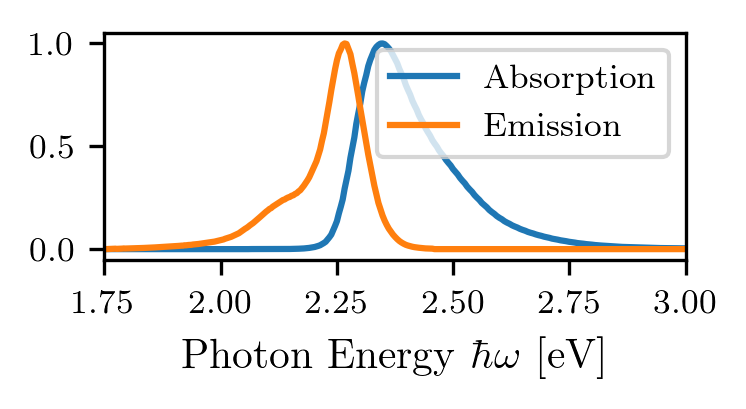

In [3]:
path_to_mol_data = (
    "/Users/chair/Documents/Academia/SuperRes/Biteen_colab/"+
    "Mispolarization/python/gitted/spectral_fitting/")

# R6G_spectrum = sio.loadmat(os.path.join(path_to_mol_data, "R6G_spectrum.mat"))
thermo_fisher_dye_data = np.loadtxt(
    os.path.join(path_to_mol_data, 'BODIPY R6G.csv'), 
    skiprows=1, 
    delimiter=','
    )
# R6G_spectrum.keys()
max_excitation_wavelength = thermo_fisher_dye_data.T[0][np.argmax(thermo_fisher_dye_data.T[1])]
max_excitation_wavelength
plt.figure(dpi=300, figsize=(2.5,1))
plt.plot(1240/thermo_fisher_dye_data.T[0], thermo_fisher_dye_data.T[1]/thermo_fisher_dye_data.T[1].max(), label='Absorption')
plt.plot(1240/thermo_fisher_dye_data.T[0], thermo_fisher_dye_data.T[2]/thermo_fisher_dye_data.T[2].max(), label='Emission')
plt.legend()
plt.xlim([1.75, 3])
plt.xlabel('Photon Energy $\hbar\omega$ [eV]', fontsize=10)

# R6G_emis = R6G_spectrum["bdpr6g"]
# # R6G_spectrum.shape

# # R6G_spectrum[1,:5]
# # plt.figure(dpi=150)
# plt.plot(1240/R6G_emis[0], R6G_emis[1])
# plt.title('R6G Emission from Curly')
# plt.xlabel('eV')

#### Plot model spectra

(1.6, 2.75)

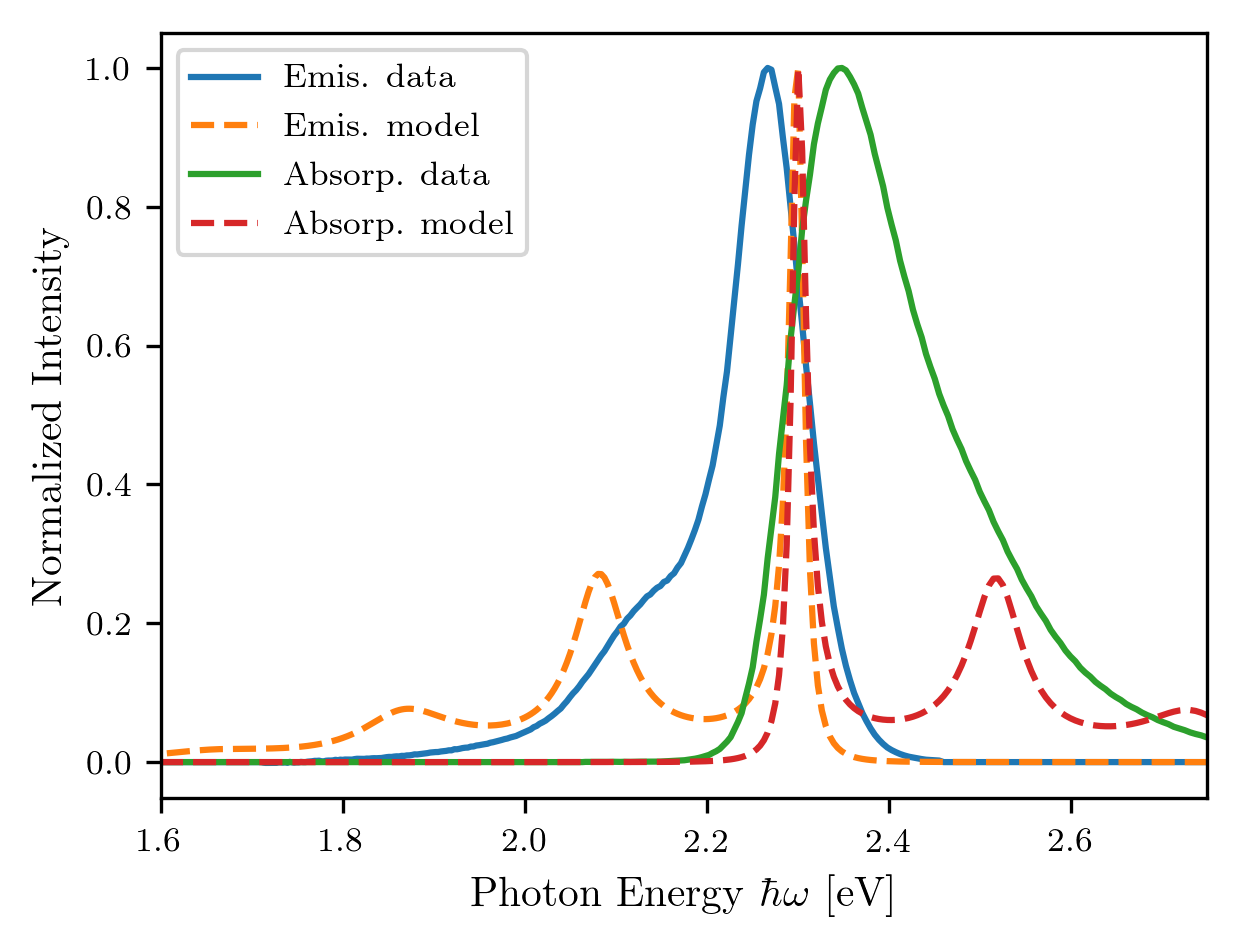

In [184]:
test_hbar_omega_eg_0 = 2.3
# test_script_d = .8
test_script_d = 1.3
test_hbar_omega_0 = .22
# test_hbar_gamma = .18
test_hbar_gamma = .05
test_t_bound = 1000
test_t_points = 10000
test_T = 300
# test_hbar_omega_eg_0 = 2.3
# test_script_d = 1.6
# test_hbar_omega_0 = .03
# test_hbar_gamma = .0015
# test_t_bound = 1000
# test_t_points = 10000
# test_T = 300

hbar_omegas = 1240/thermo_fisher_dye_data.T[0]

## Plot emission data 
plt.plot(1240/thermo_fisher_dye_data.T[0], thermo_fisher_dye_data.T[2]/thermo_fisher_dye_data.T[2].max(), label='Emis. data')

## Build emission model 
emission = dom.sigma_e(
#         (omegas-(1/2*test_script_d**2.*test_hbar_omega_0/hbar)), 
        (
            hbar_omegas/hbar - test_hbar_omega_eg_0/hbar
            -
            (1/2 * test_script_d**2. * test_hbar_omega_0/hbar)),
        script_d=test_script_d, 
        omega_q=test_hbar_omega_0/hbar,
        gamma=test_hbar_gamma/hbar,
        t_bound=test_t_bound, 
        t_points=test_t_points,
        T = test_T
        )

plt.plot(
    hbar_omegas, 
    emission/emission.max(),
    ls='--', 
    label='Emis. model'
    )



## Plot Absorption Data
plt.plot(1240/thermo_fisher_dye_data.T[0], thermo_fisher_dye_data.T[1]/thermo_fisher_dye_data.T[1].max(), label='Absorp. data')



## Build abs model
absorption = dom.sigma_a(
#         (omegas-(1/2*test_script_d**2.*test_hbar_omega_0/hbar)), 
        (
            hbar_omegas/hbar - test_hbar_omega_eg_0/hbar
            -
            (1/2 * test_script_d**2. * test_hbar_omega_0/hbar)),
        script_d=test_script_d, 
        omega_q=test_hbar_omega_0/hbar,
        gamma=test_hbar_gamma/hbar,
        t_bound=test_t_bound, 
        t_points=test_t_points,
        T = test_T
        )


plt.plot(
    hbar_omegas, 
    absorption/absorption.max(),
    ls='--', 
    label='Absorp. model'
    )




plt.xlabel('Photon Energy $\hbar\omega$ [eV]', fontsize=10)
plt.ylabel('Normalized Intensity', fontsize=10)
plt.legend()

plt.xlim([1.6,2.75])

#### Test forier transform of correlation function

In [185]:
hw = hbar_omegas

shifted_w = (
    hbar_omegas/hbar - test_hbar_omega_eg_0/hbar
    -
    (1/2 * test_script_d**2. * test_hbar_omega_0/hbar)
    )

# scale_factor = 1e-30
drive_amp = 1e-75
c_w = dom.sigma_e(
#         (omegas-(1/2*test_script_d**2.*test_hbar_omega_0/hbar)), 
    shifted_w,
    script_d=test_script_d, 
    omega_q=test_hbar_omega_0/hbar,
    gamma=test_hbar_gamma/hbar,
    t_bound=test_t_bound, 
    t_points=test_t_points,
    T = test_T
    )
# c_w = dom.for_cor_fun(
#     shifted_w, 
#     test_script_d,
#     test_hbar_omega_0/hbar,
#     test_hbar_gamma/hbar,
#     T=300,
#     take_conjugate=False,
#     )*-1j/hbar * 1e-30

# c_w_conj = dom.for_cor_fun(
#     shifted_w, 
#     test_script_d,
#     test_hbar_omega_0/hbar,
#     test_hbar_gamma/hbar,
#     T=300,
#     take_conjugate=True,
#     )*-1j/hbar * 1e-30

In [186]:

plas_parameters = [
    9.82335326,  # eps_inf
    9.06705560,  # w_p
    0.0334860149,  # gamma
    1.33**2.,  # eps_b
    41*1e-7  # a
    ]


dcol = np.array([[10, 0, 0]])


def alpha_pla_of_w(w): 
    alpha = cp.sparse_ret_sphere_polarizability_Drude(
        w=hw/hbar, 
        eps_inf=plas_parameters[0], 
        w_p=plas_parameters[1]/hbar, 
        gamma=plas_parameters[2]/hbar, 
        eps_b=plas_parameters[3], 
        a=plas_parameters[4]
        )
    return alpha

## Define uncoupled plasmon spectrum
def plas_scat(w):
    spec = (
        cp.sigma_prefactor(w, eps_b = plas_parameters[3])
        *
        np.abs(alpha_pla_of_w(w)[...,0,0])**2.
        )
    return spec
        


def dips_per_om(w):
    return cp.plas_dip_driven_by_mol(
        0, 0, dcol,
#         -c_w_conj,
        mol_dipole_mag=1J*c_w/hbar*drive_amp,
        E_d_angle=0, 
        drive_hbar_w=w,
        alpha1_diag=alpha_pla_of_w(hw),
        n_b=1,
#         drive_amp=drive_amp
        )

In [187]:
scat, comps = cp.sigma_scat_coupled(
    dips_per_om,
    dcol, 
    hw/hbar,
    n_b=1,
    E_0=drive_amp,
    )

(1.2412412412412412, 3)

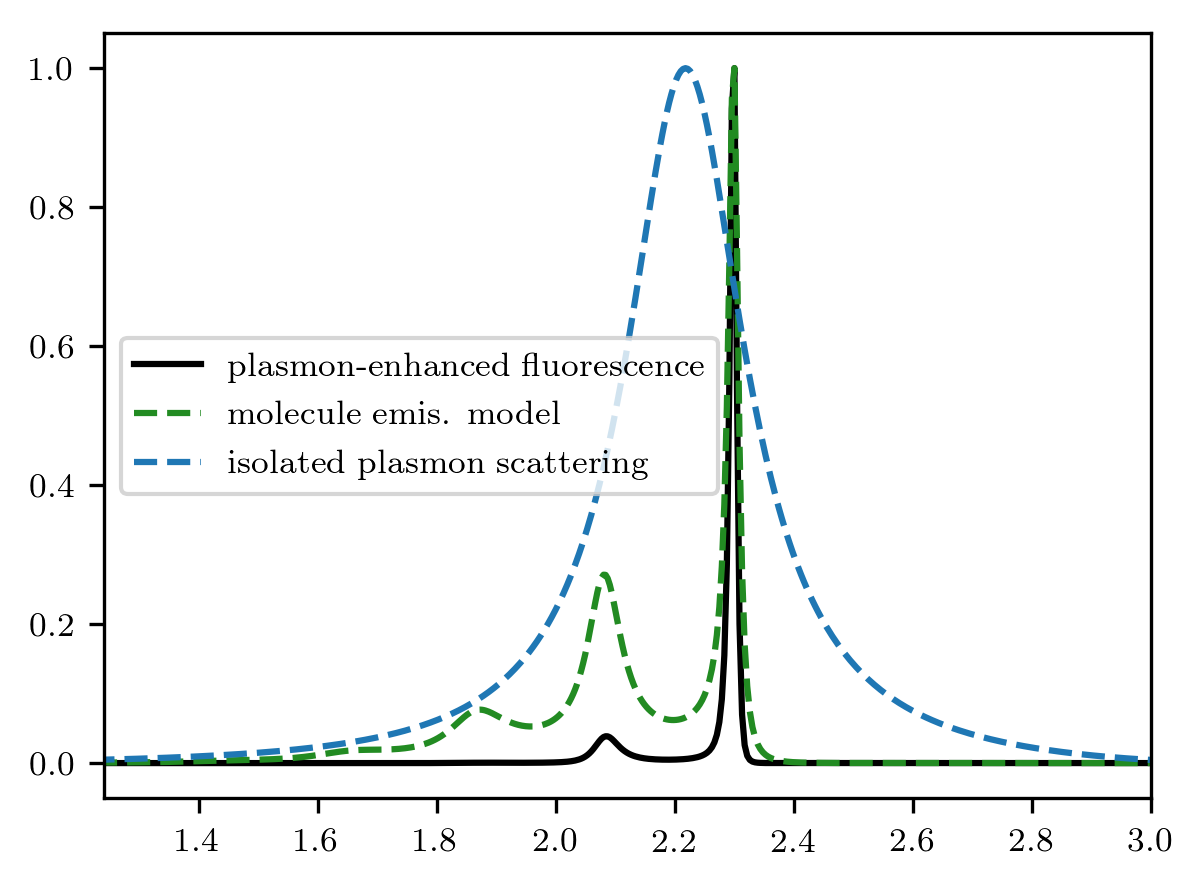

In [188]:
plt.plot(
    hw, scat/scat.max(), 
    c='black',
    label='plasmon-enhanced fluorescence')
plt.plot(
    hbar_omegas, 
    emission/emission.max(),
    c='forestgreen',
    ls='--', 
    label='molecule emis. model'
    )
plt.plot(
    hw, 
    plas_scat(hw/hbar)/plas_scat(hw/hbar).max(),
    c='C0',
    ls='--',
    label='isolated plasmon scattering')
plt.legend()
plt.xlim([hw.min(), 3])

## Make some figures 

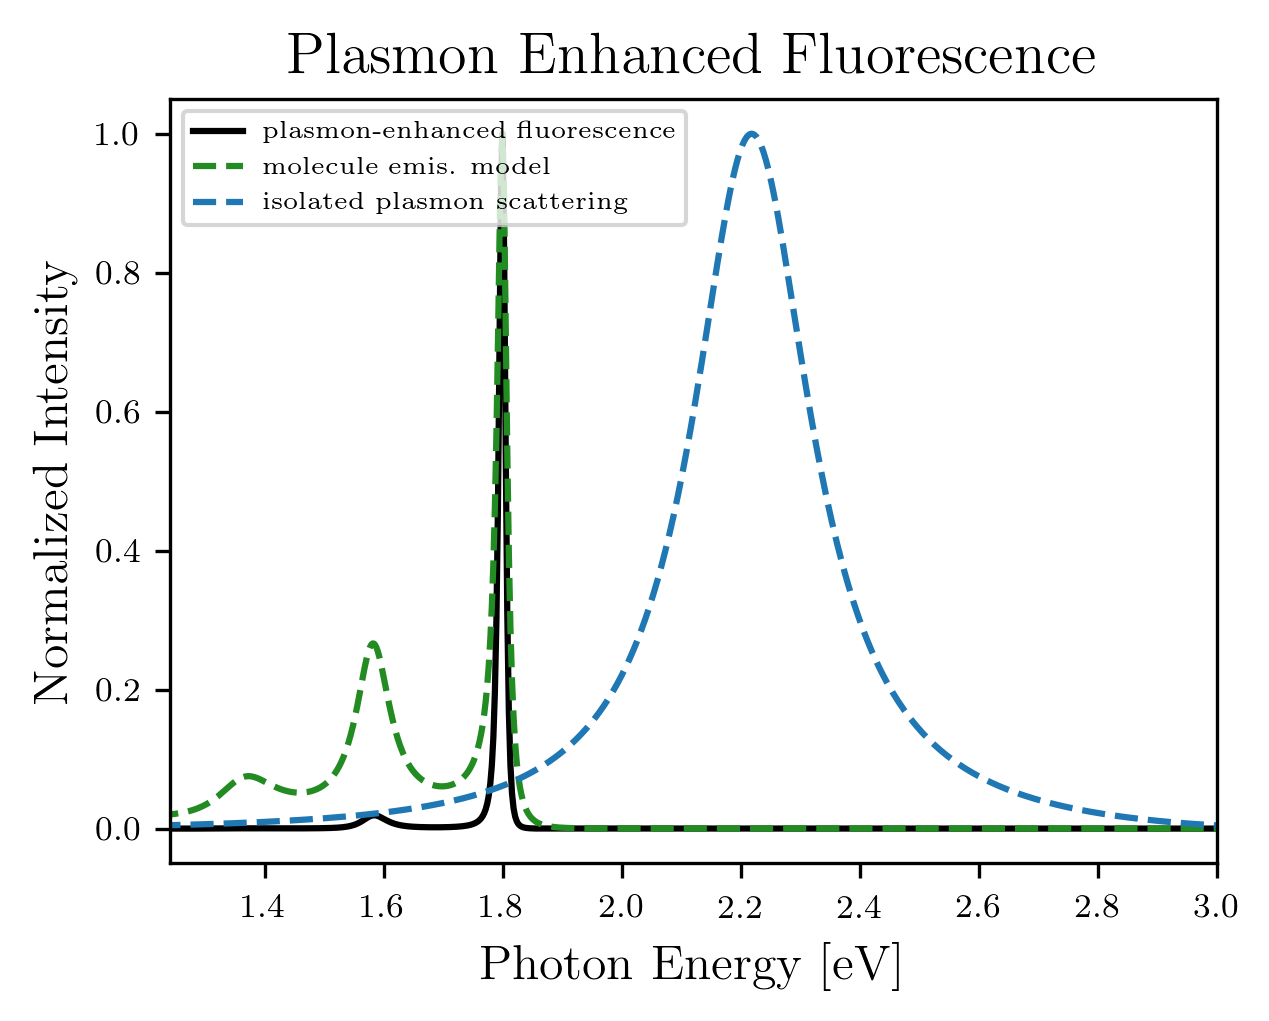

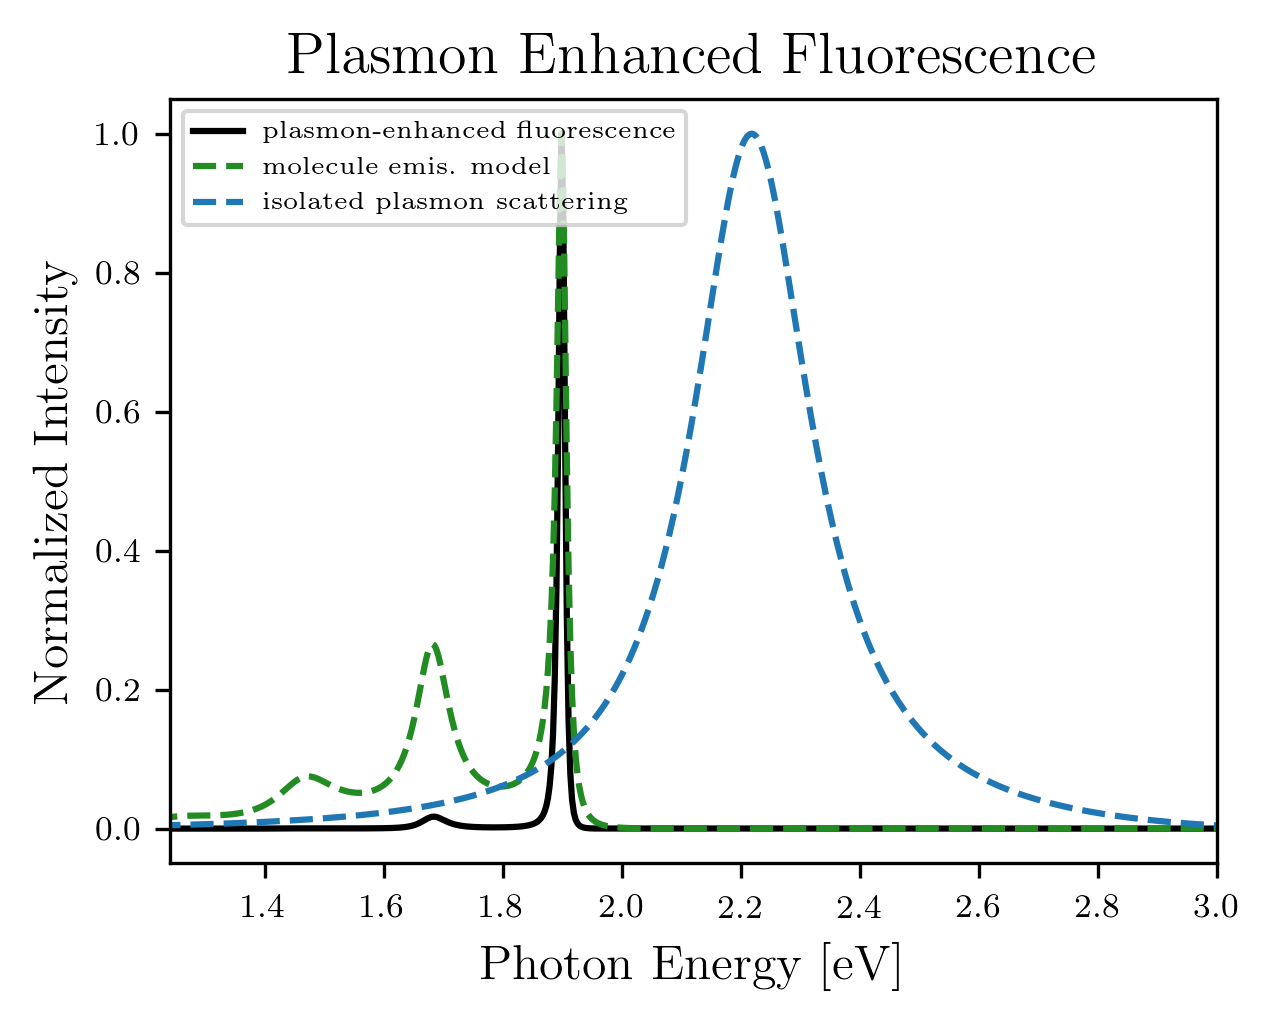

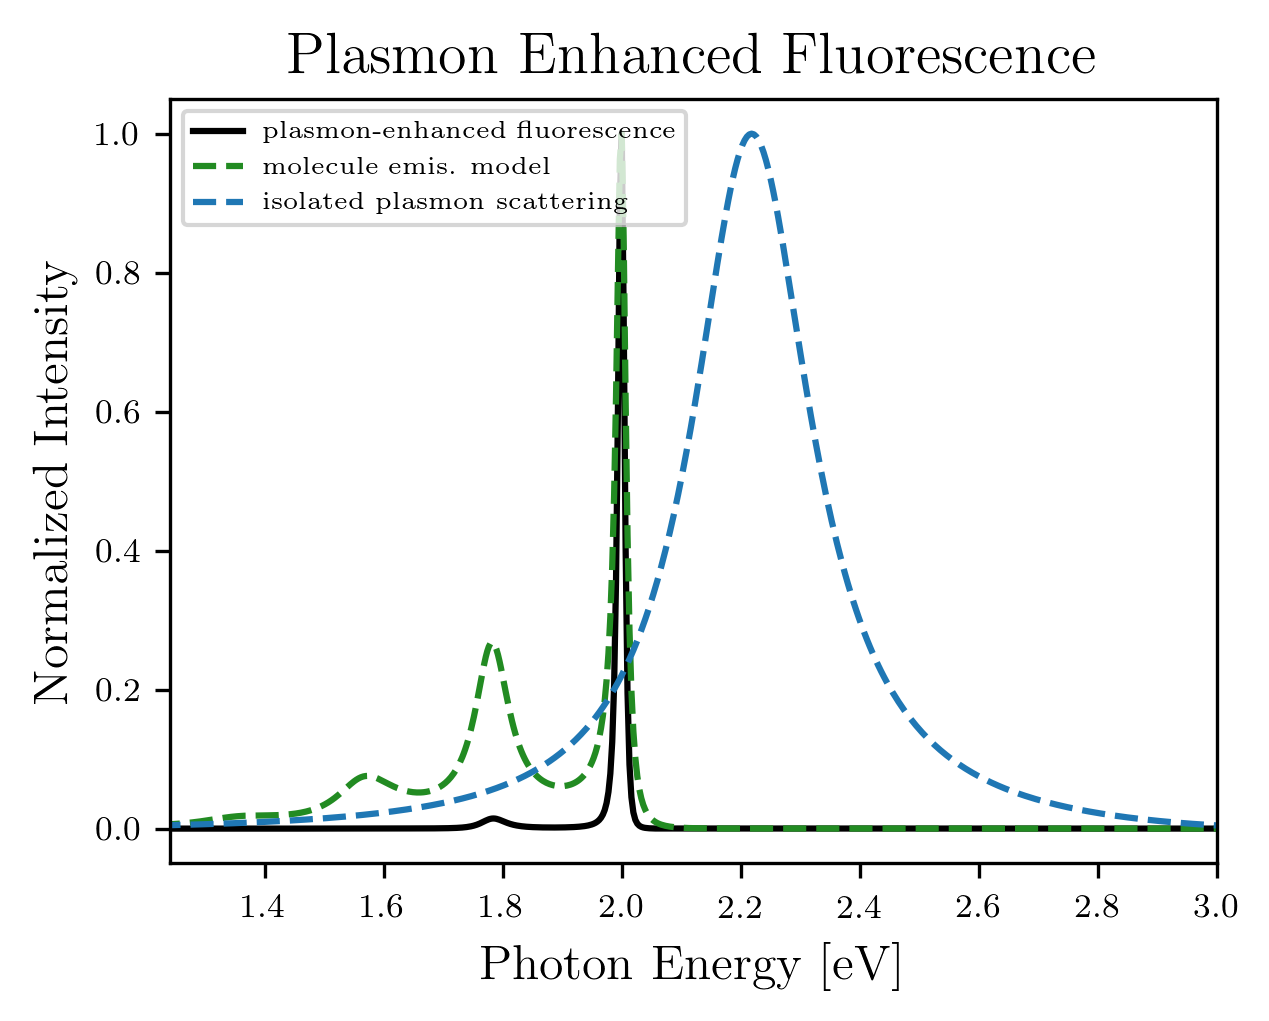

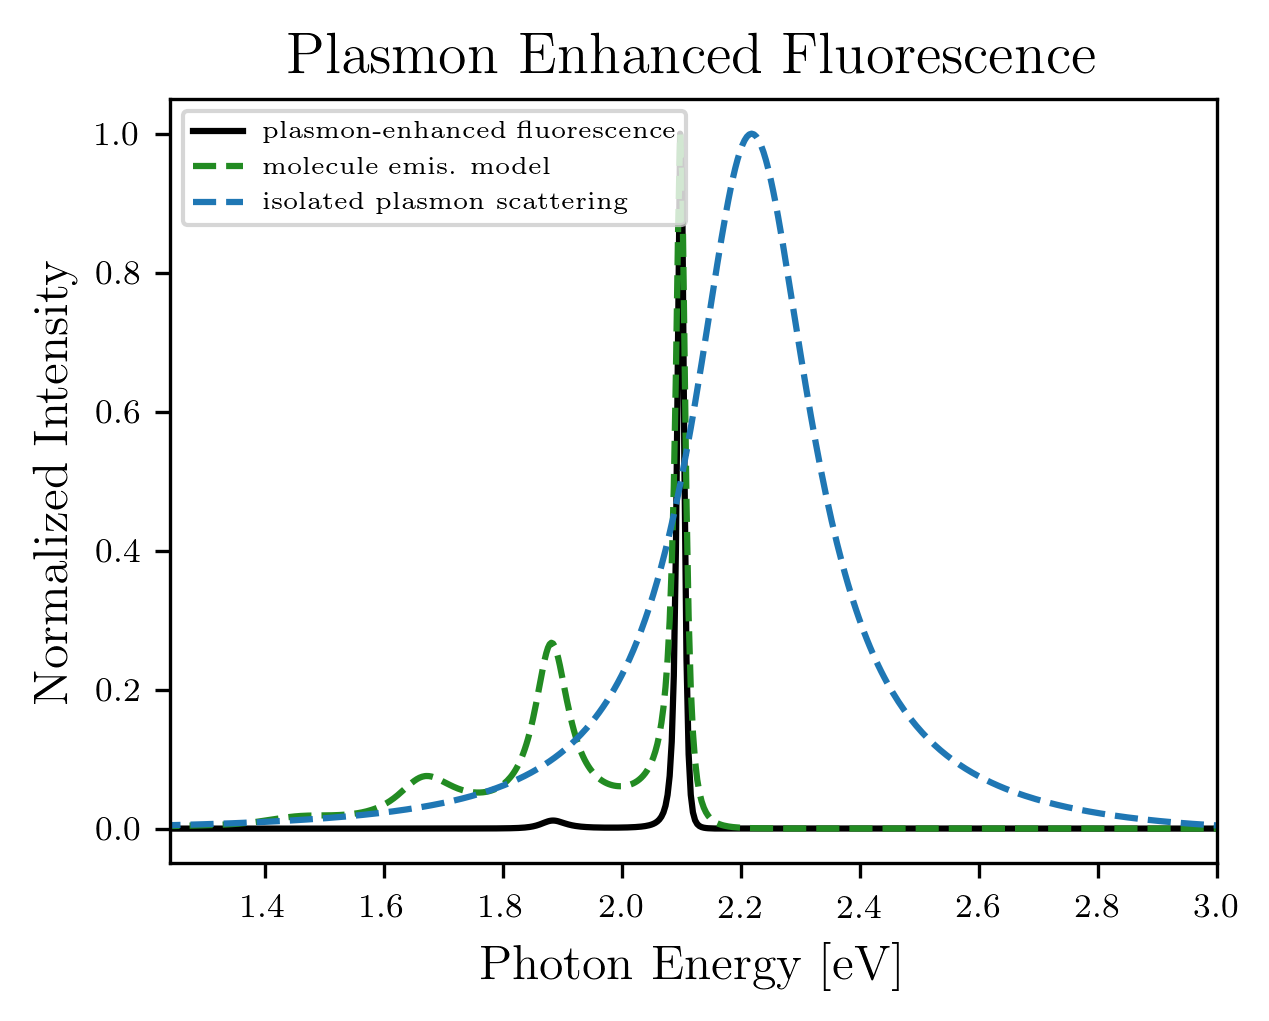

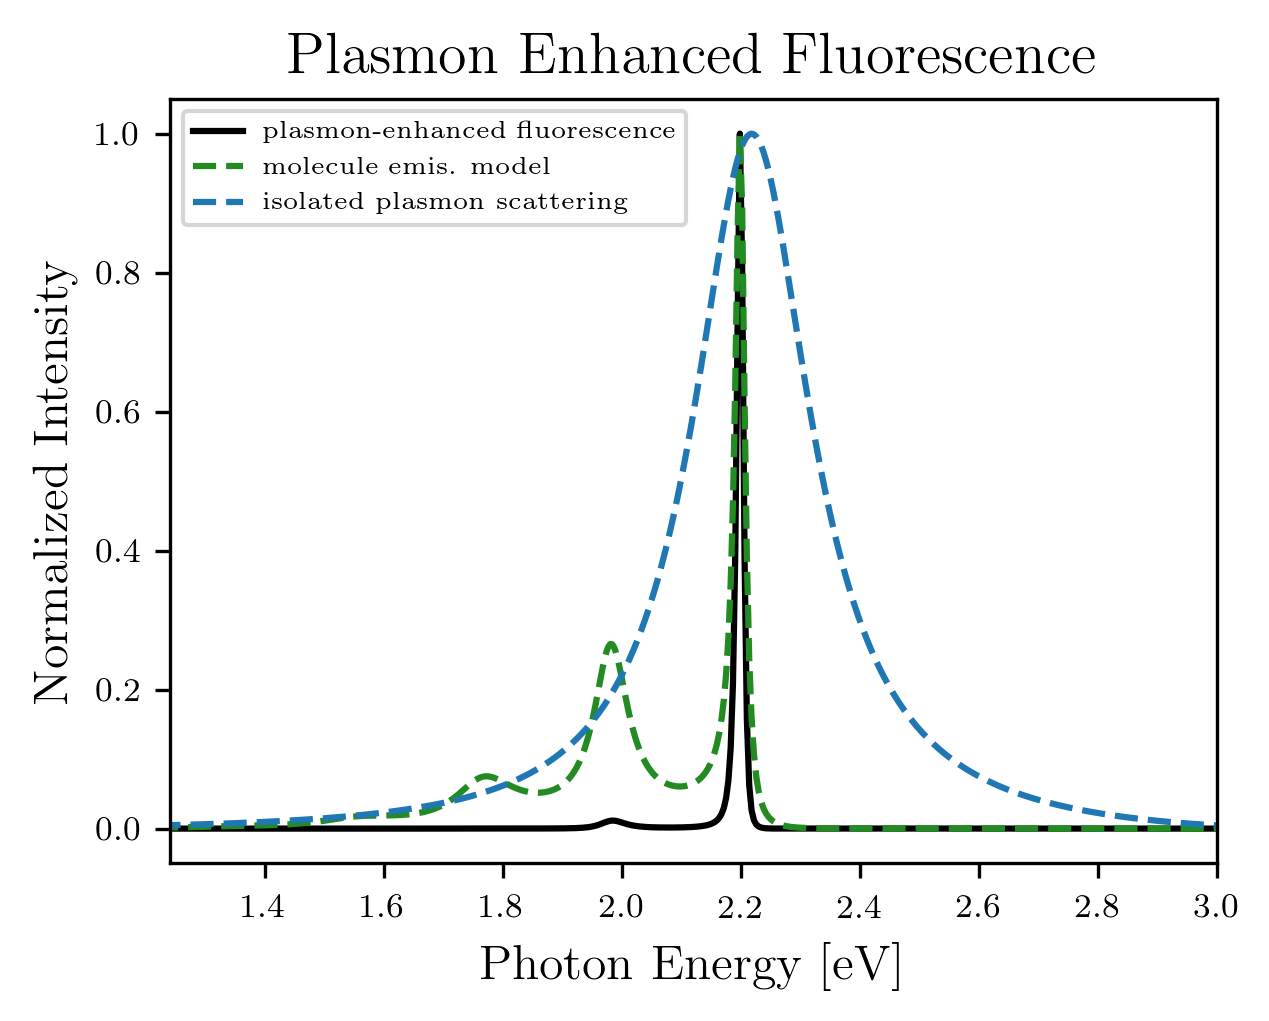

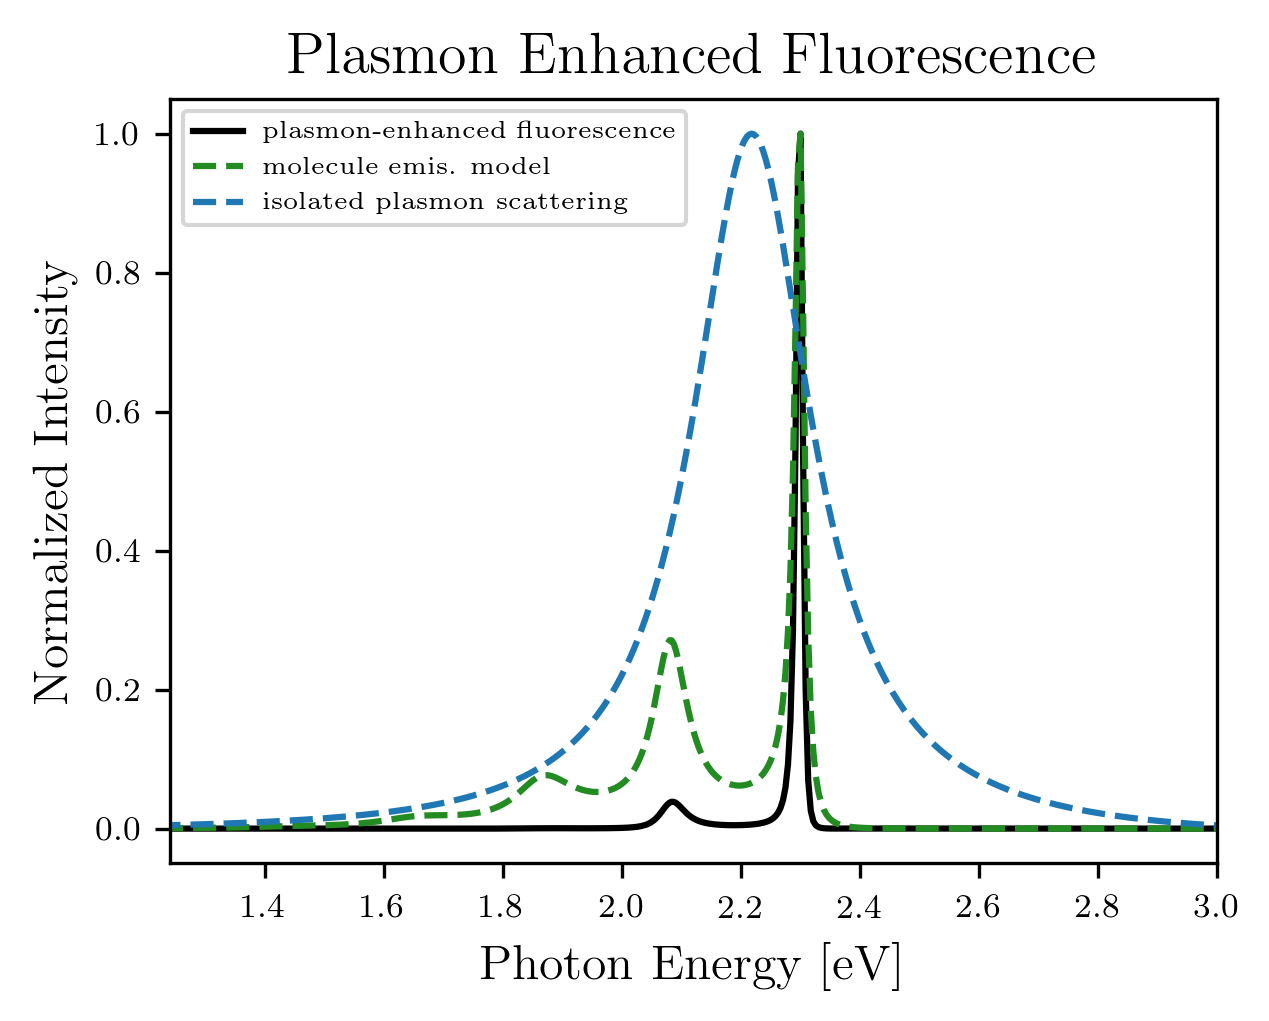

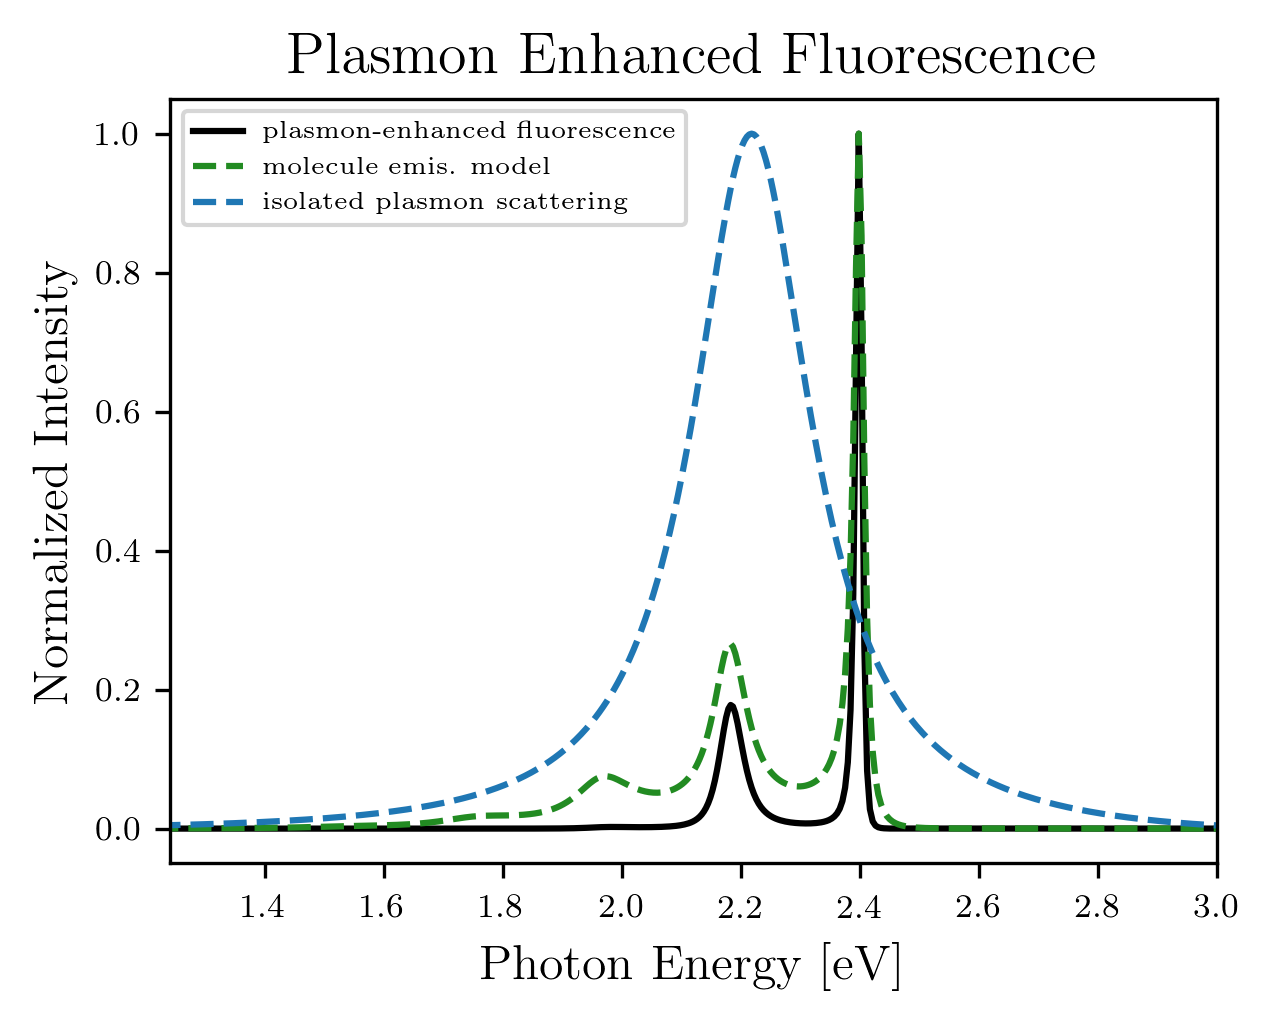

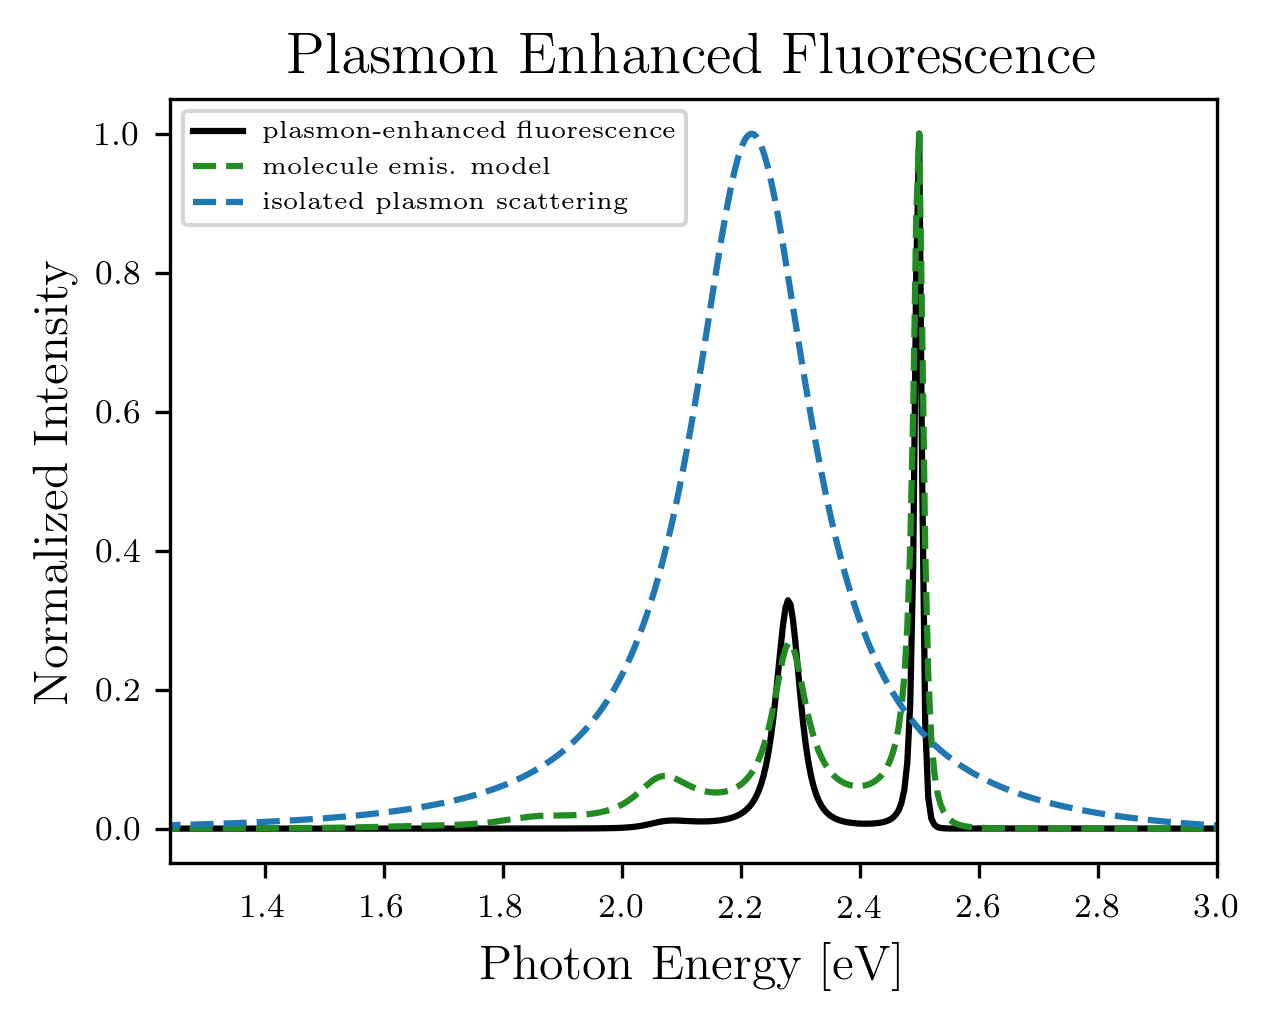

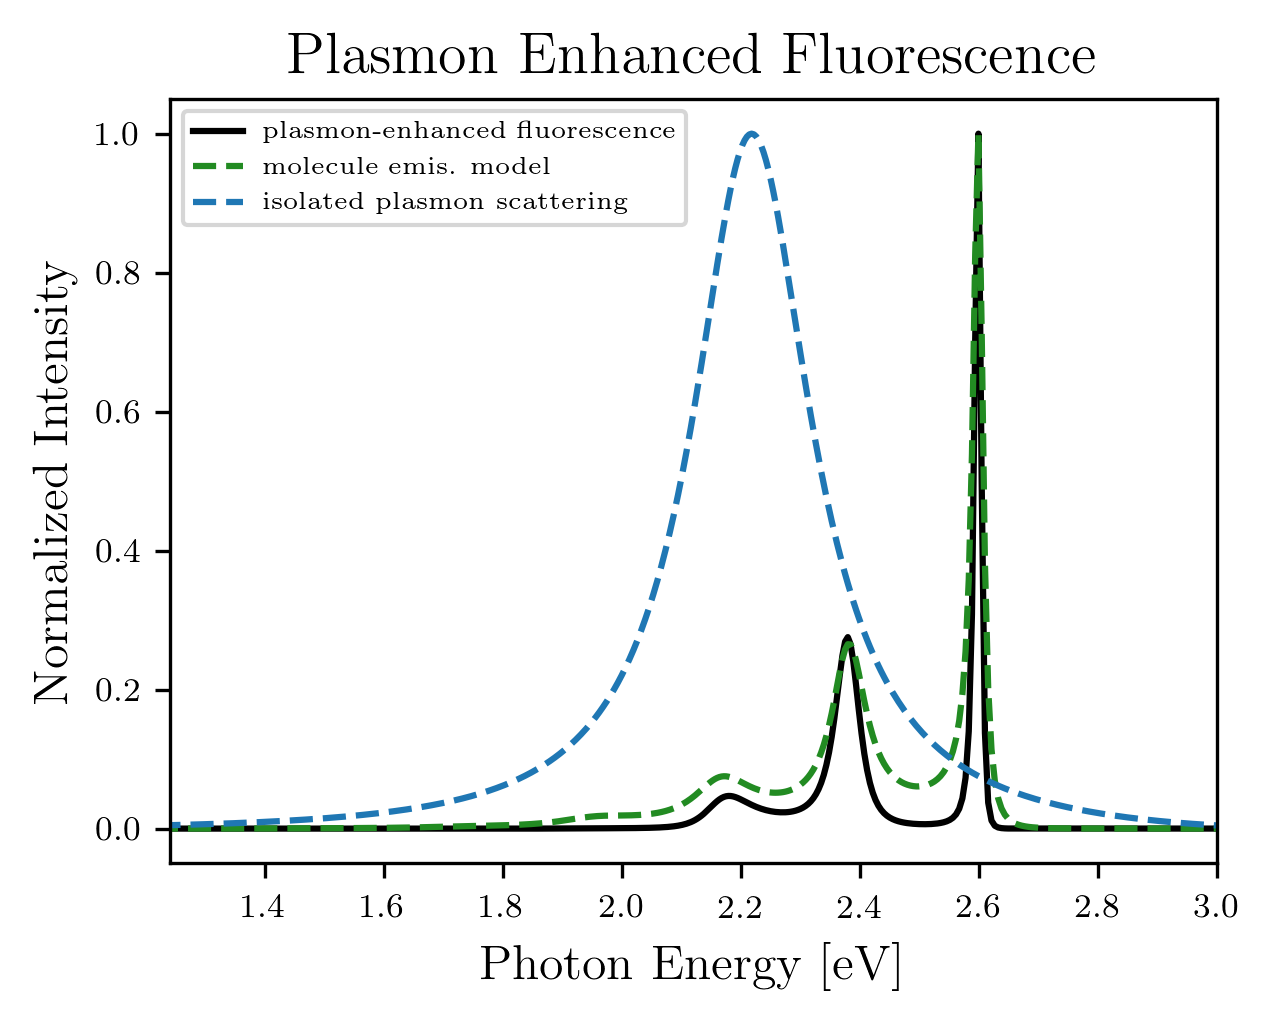

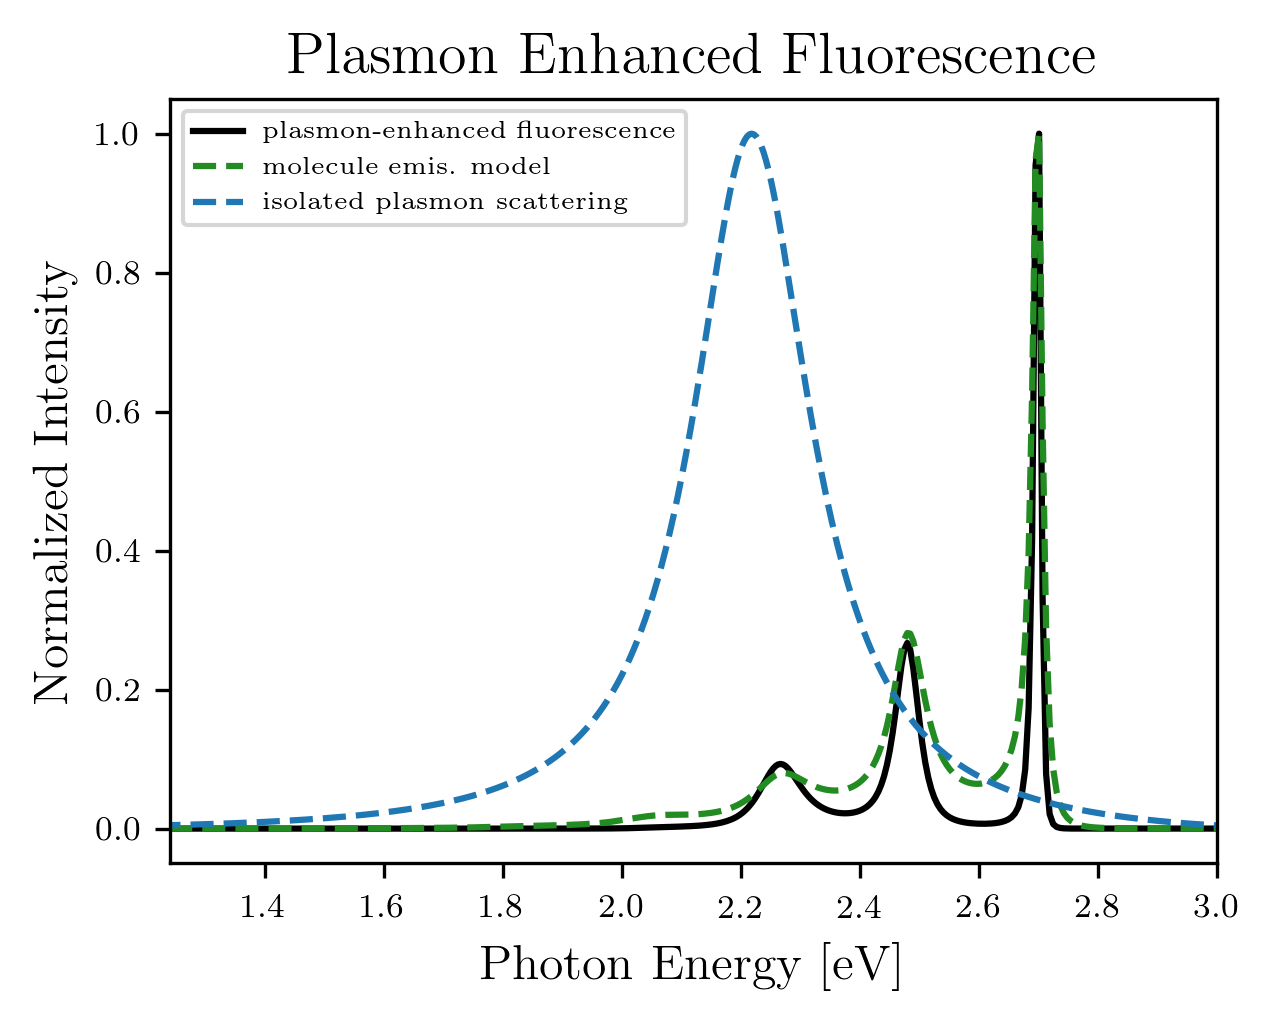

In [115]:

## Define parameters for modeled spetra
plas_parameters = [
    9.82335326,  # eps_inf
    9.06705560,  # w_p
    0.0334860149,  # gamma
    1.33**2.,  # eps_b
    41*1e-7  # a
    ]
dcol = np.array([[100, 0, 0]])

## Iterate through spectral positions of molecule
for i in np.arange(-.5, .5, .1):
    further_shift = i/hbar

    ## Define plasmon polarizability as a function of frequency
    def alpha_pla_of_w(w): 
        alpha = cp.sparse_ret_sphere_polarizability_Drude(
            w=hw/hbar, 
            eps_inf=plas_parameters[0], 
            w_p=plas_parameters[1]/hbar, 
            gamma=plas_parameters[2]/hbar, 
            eps_b=plas_parameters[3], 
            a=plas_parameters[4]
            )
        return alpha

    ## Define uncoupled plasmon spectrum
    def plas_scat(w):
        spec = (
            cp.sigma_prefactor(w, eps_b = plas_parameters[3])
            *
            np.abs(alpha_pla_of_w(w)[...,0,0])**2.
            )
        return spec

    ## Define molecule dipole moment 
    c_w = dom.sigma_e(
    #         (omegas-(1/2*test_script_d**2.*test_hbar_omega_0/hbar)), 
        shifted_w-further_shift,
        script_d=test_script_d, 
        omega_q=test_hbar_omega_0/hbar,
        gamma=test_hbar_gamma/hbar,
        t_bound=test_t_bound, 
        t_points=test_t_points,
        T = test_T
        )

    ## Define coupled dipole amplitudes as a function of frequency 
    def dips_per_om(w):
        return cp.plas_dip_driven_by_mol(
            0, 0, dcol,
    #         -c_w_conj,
            mol_dipole_mag=1J*c_w/hbar*drive_amp,
            E_d_angle=0, 
            drive_hbar_w=w,
            alpha1_diag=alpha_pla_of_w(hw),
            n_b=1,
    #         drive_amp=drive_amp
            )

    scat, comps = cp.sigma_scat_coupled(
        dips_per_om,
        dcol, 
        hw/hbar,
        n_b=1,
        E_0=drive_amp,
        )

    plt.plot(
        hw, scat/scat.max(), 
        c='black',
        label='plasmon-enhanced fluorescence')
    ## plot molecule emission 
    emission = np.real(c_w)
    plt.plot(
        hbar_omegas, 
        emission/emission.max(),
        c='forestgreen',
        ls='--', 
        label='molecule emis. model'
        )
    plt.plot(
        hw, 
        plas_scat(hw/hbar)/plas_scat(hw/hbar).max(),
        c='C0',
        ls='--',
        label='isolated plasmon scattering')
    plt.legend(fontsize=6)
    plt.xlim([hw.min(), 3])
    plt.ylabel('Normalized Intensity')
    plt.xlabel('Photon Energy [eV]')
    plt.title('Plasmon Enhanced Fluorescence')
    plt.show()

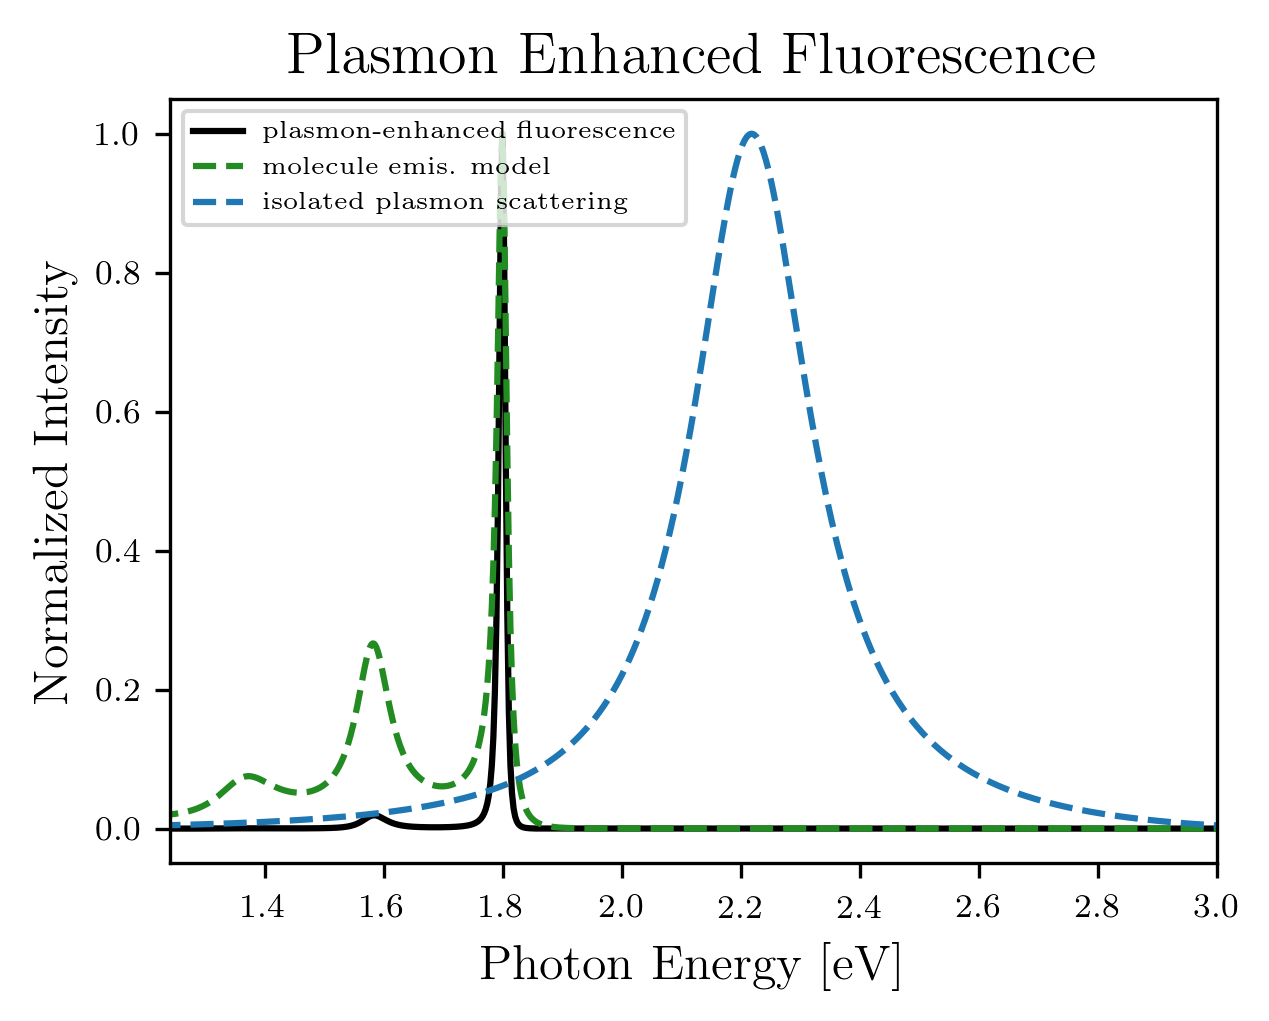

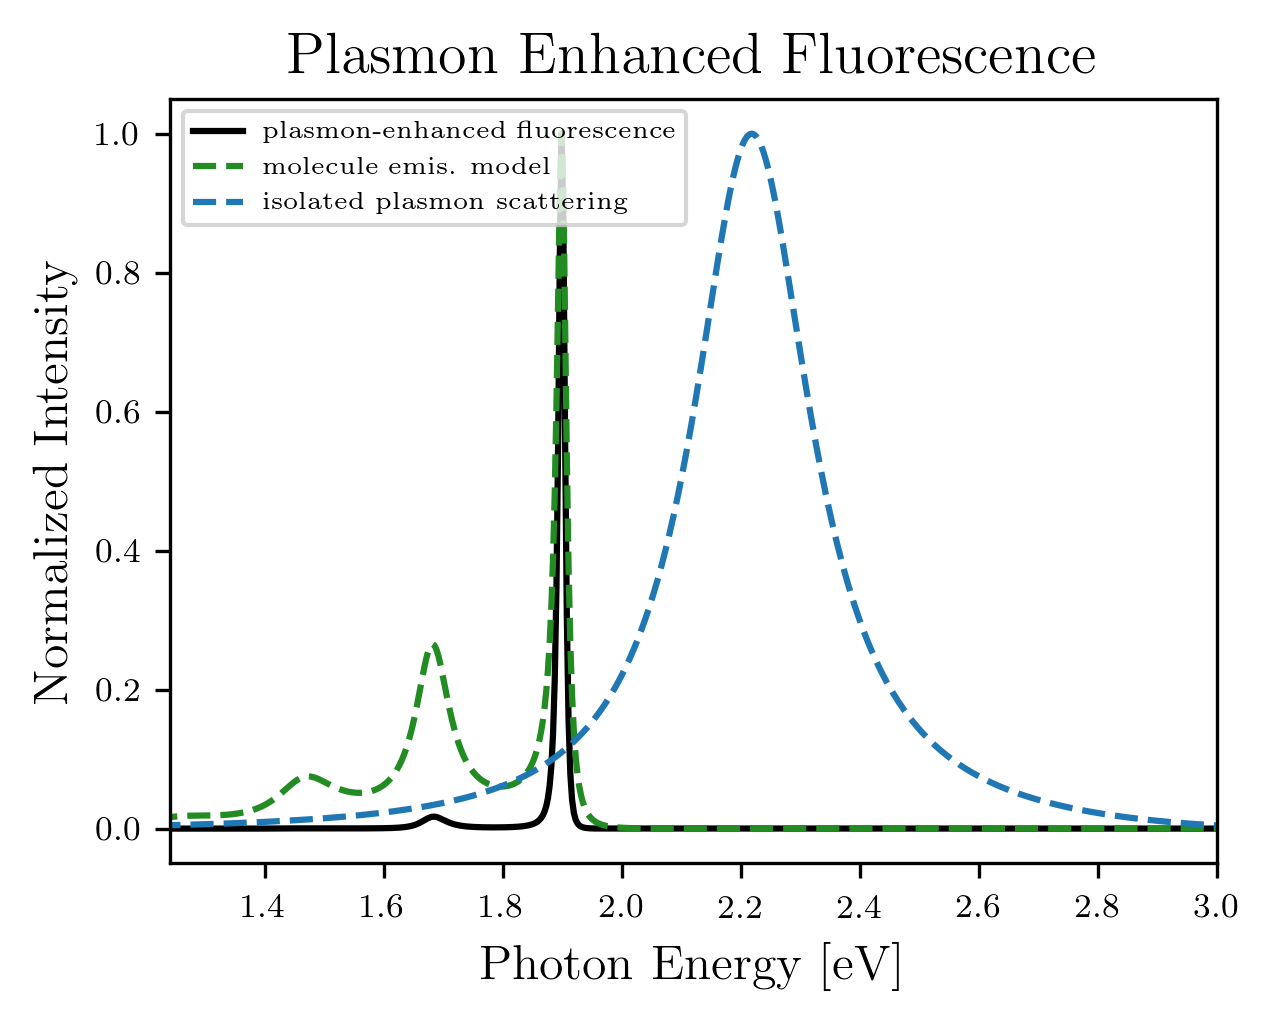

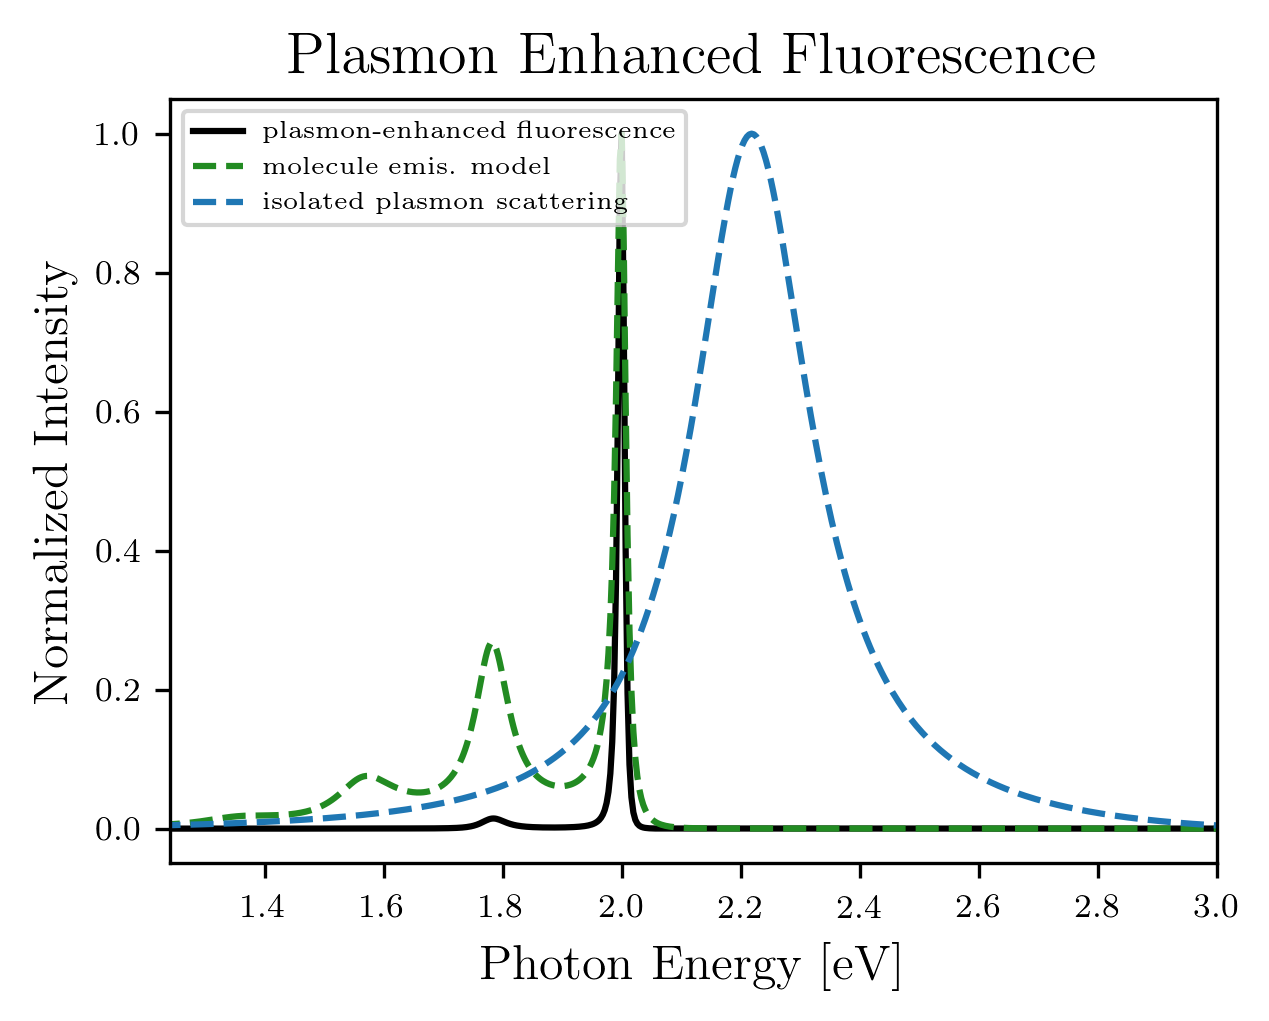

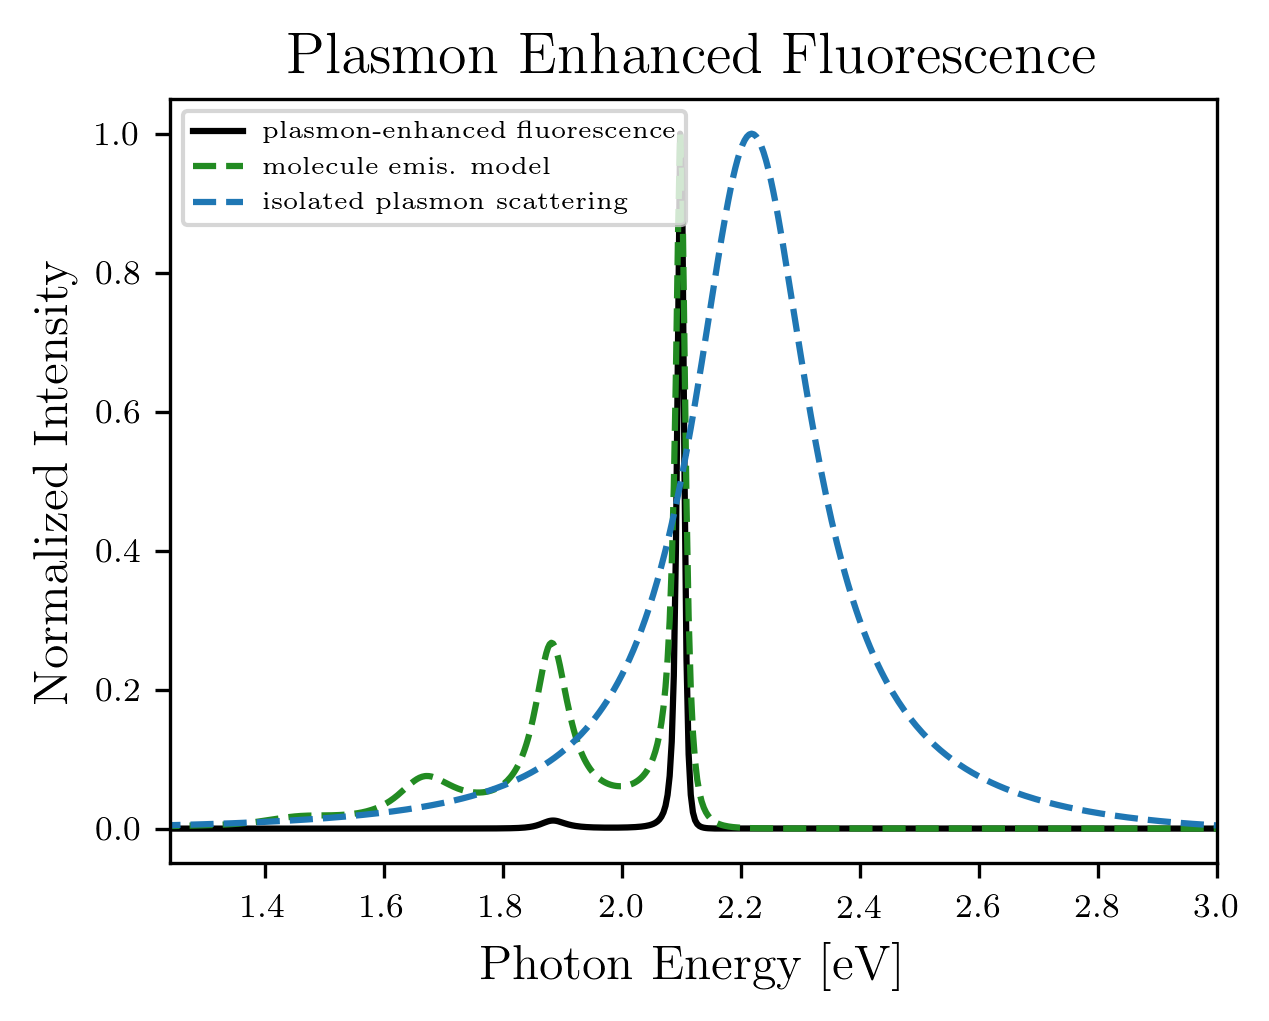

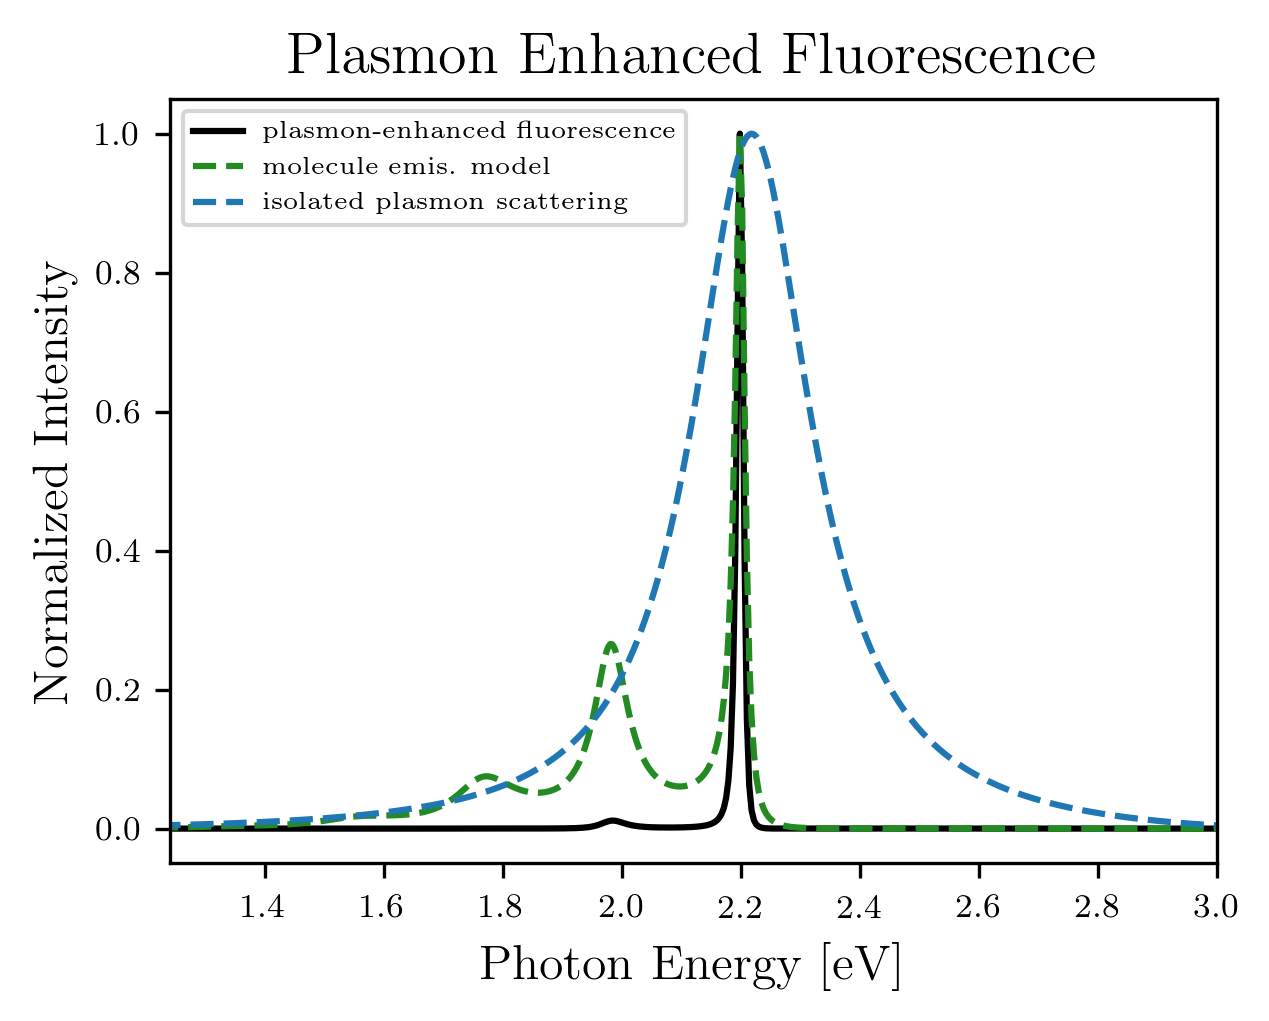

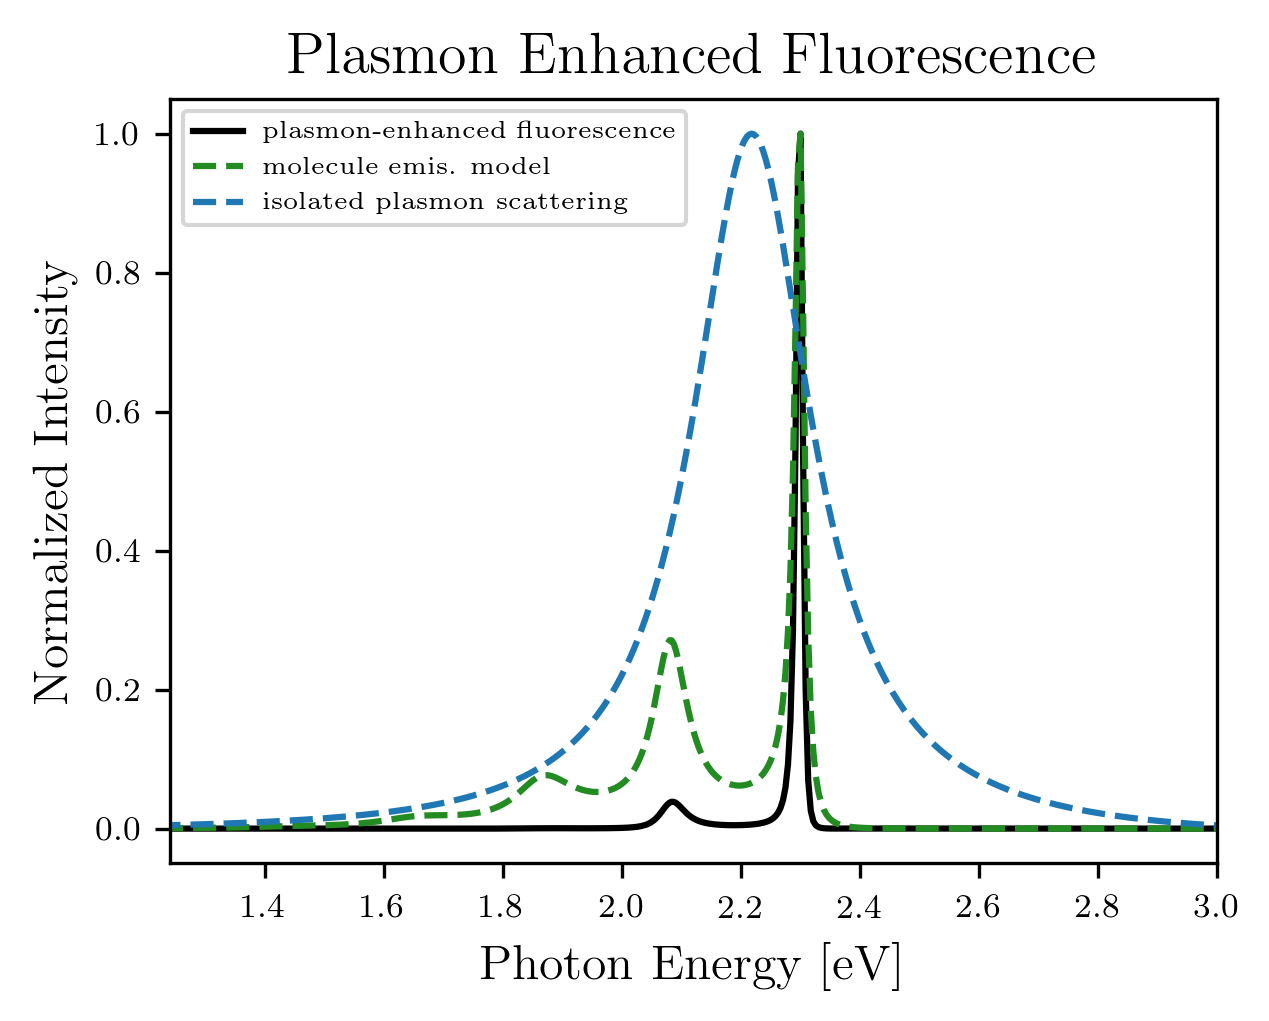

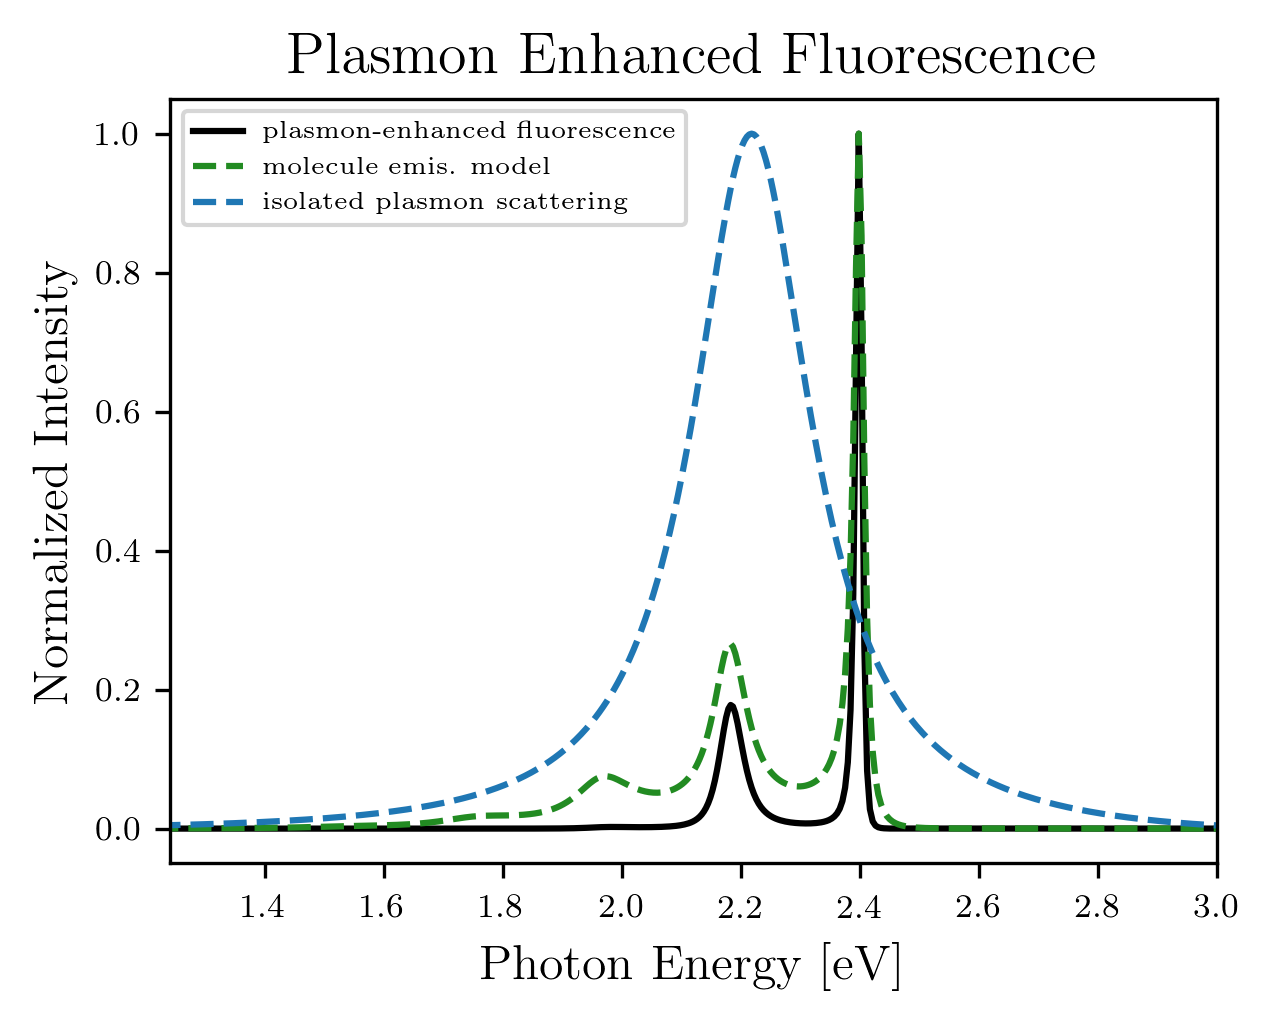

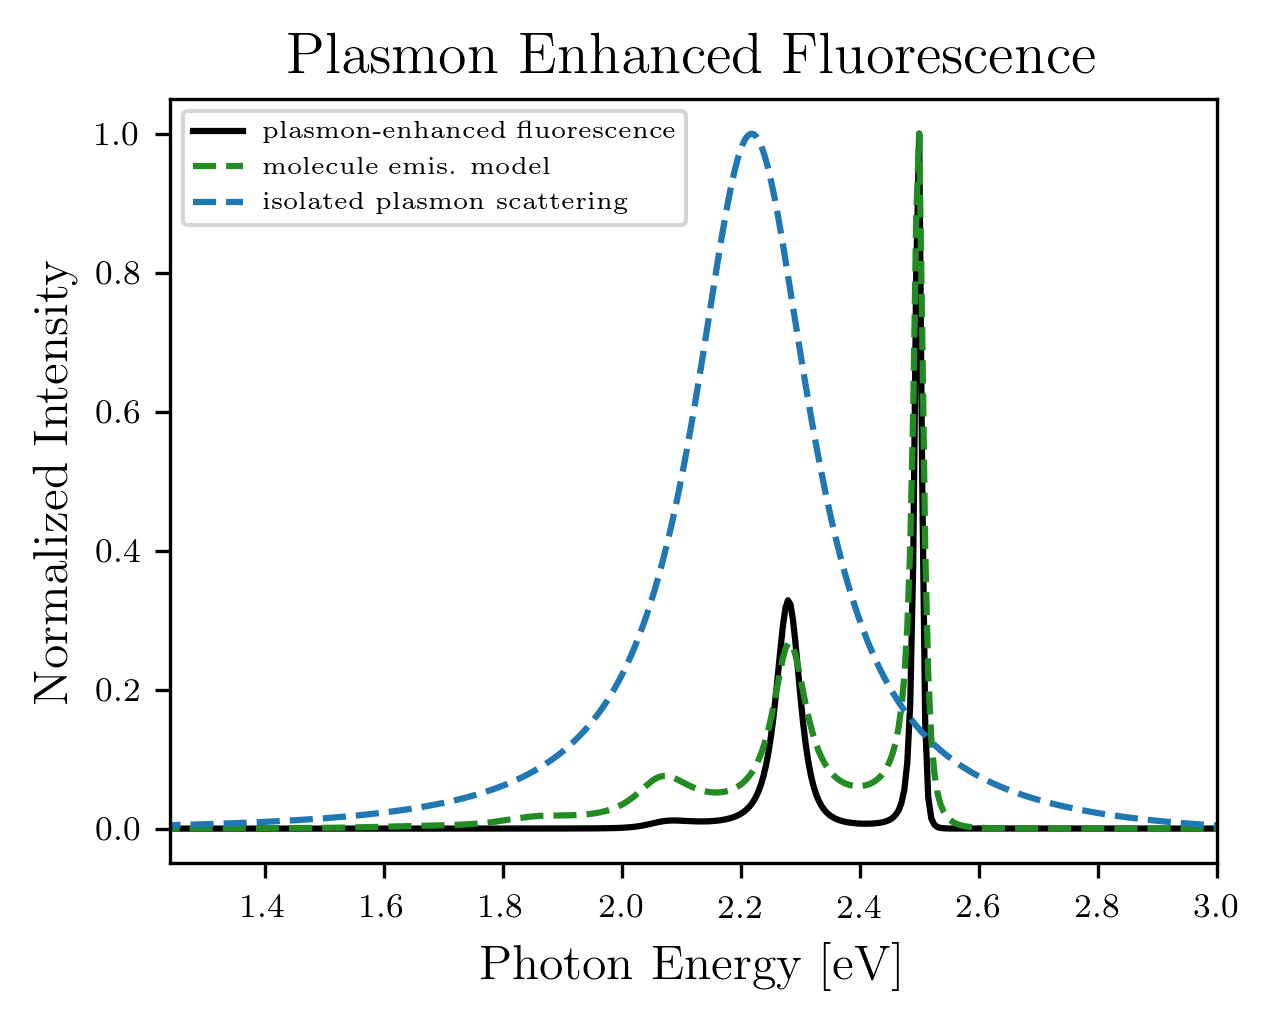

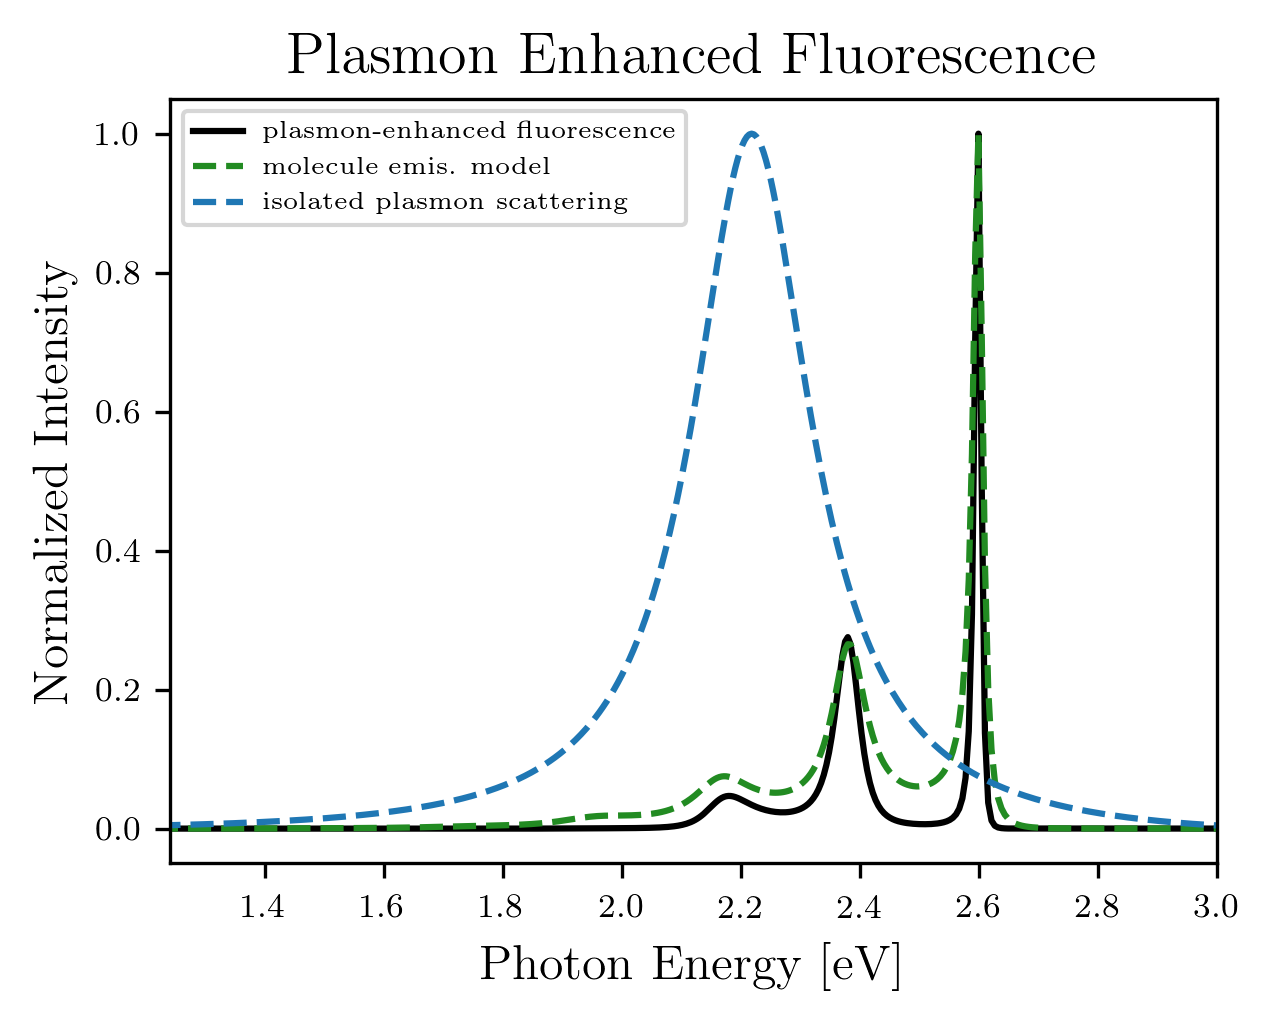

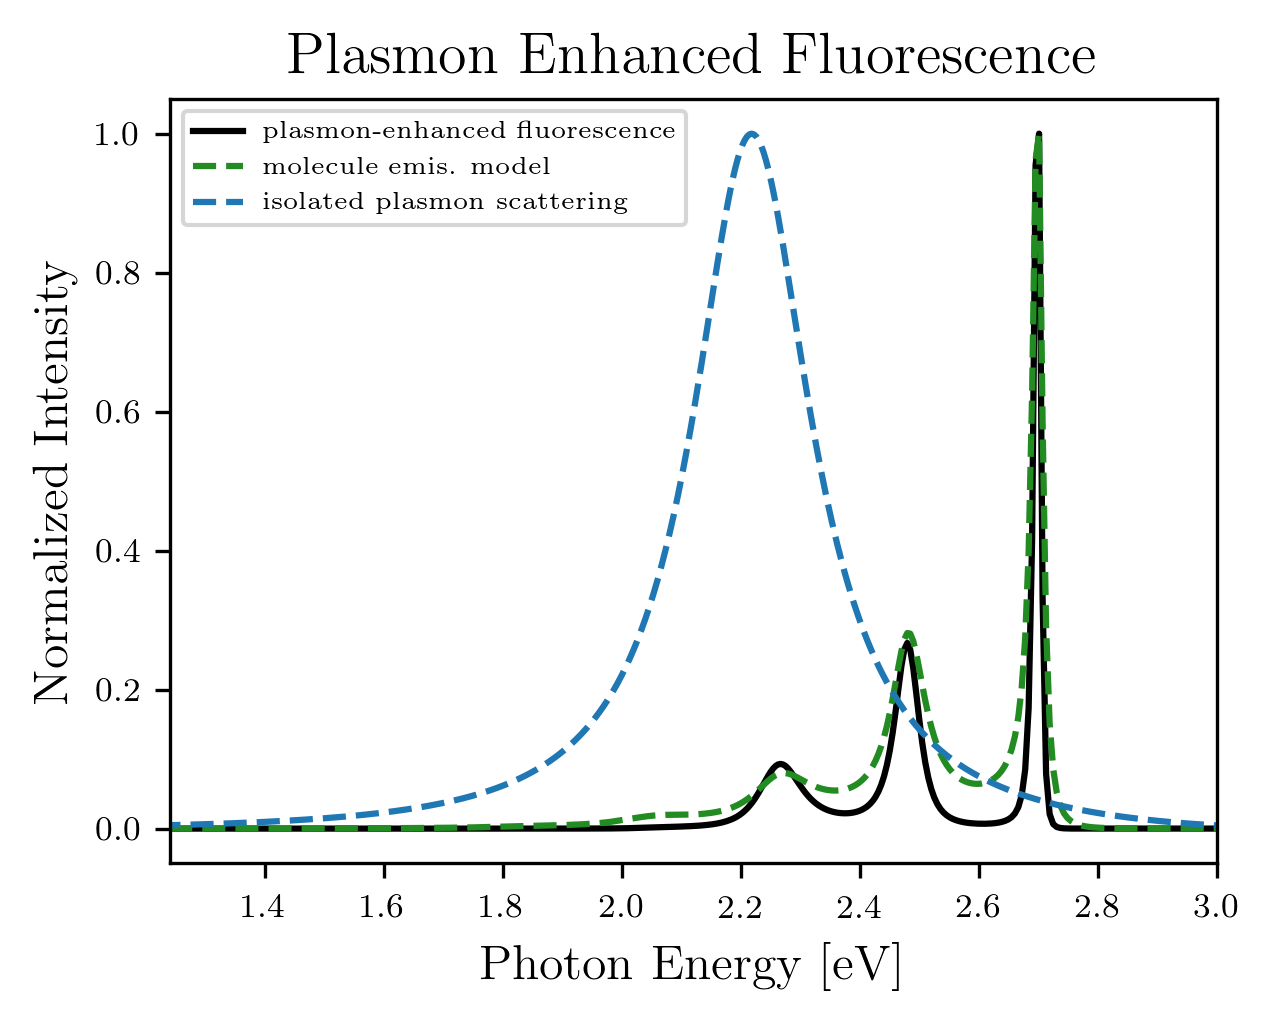

In [166]:

## Define parameters for modeled spetra
plas_parameters = [
    9.82335326,  # eps_inf
    9.06705560,  # w_p
    0.0334860149,  # gamma
    1.33**2.,  # eps_b
    41*1e-7  # a
    ]
dcol = np.array([[100, 0, 0]])*1e-7

## Iterate through spectral positions of molecule
for i in np.arange(-.5, .5, .1):
    further_shift = i/hbar

    ## Define plasmon polarizability as a function of frequency
    def alpha_pla_of_w(w): 
        alpha = cp.sparse_ret_sphere_polarizability_Drude(
            w=hw/hbar, 
            eps_inf=plas_parameters[0], 
            w_p=plas_parameters[1]/hbar, 
            gamma=plas_parameters[2]/hbar, 
            eps_b=plas_parameters[3], 
            a=plas_parameters[4]
            )
        return alpha

    ## Define uncoupled plasmon spectrum
    def plas_scat(w):
        spec = (
            cp.sigma_prefactor(w, eps_b = plas_parameters[3])
            *
            np.abs(alpha_pla_of_w(w)[...,0,0])**2.
            )
        return spec

    ## Define molecule dipole moment 
    c_w = dom.sigma_e(
    #         (omegas-(1/2*test_script_d**2.*test_hbar_omega_0/hbar)), 
        shifted_w-further_shift,
        script_d=test_script_d, 
        omega_q=test_hbar_omega_0/hbar,
        gamma=test_hbar_gamma/hbar,
        t_bound=test_t_bound, 
        t_points=test_t_points,
        T = test_T
        )

    ## Define coupled dipole amplitudes as a function of frequency 
    def dips_per_om(w):
        return cp.plas_dip_driven_by_mol(
            0, 0, dcol,
    #         -c_w_conj,
            mol_dipole_mag=1J*c_w/hbar*drive_amp,
            E_d_angle=0, 
            drive_hbar_w=w,
            alpha1_diag=alpha_pla_of_w(hw),
            n_b=1,
    #         drive_amp=drive_amp
            )

    scat, comps = cp.sigma_scat_coupled(
        dips_per_om,
        dcol, 
        hw/hbar,
        n_b=1,
        E_0=drive_amp,
        )

    plt.plot(
        hw, scat/scat.max(), 
        c='black',
        label='plasmon-enhanced fluorescence')
    ## plot molecule emission 
    emission = np.real(c_w)
    plt.plot(
        hbar_omegas, 
        emission/emission.max(),
        c='forestgreen',
        ls='--', 
        label='molecule emis. model'
        )
    plt.plot(
        hw, 
        plas_scat(hw/hbar)/plas_scat(hw/hbar).max(),
        c='C0',
        ls='--',
        label='isolated plasmon scattering')
    plt.legend(fontsize=6)
    plt.xlim([hw.min(), 3])
    plt.ylabel('Normalized Intensity')
    plt.xlabel('Photon Energy [eV]')
    plt.title('Plasmon Enhanced Fluorescence')
    plt.show()

### Plotting affect of seperation

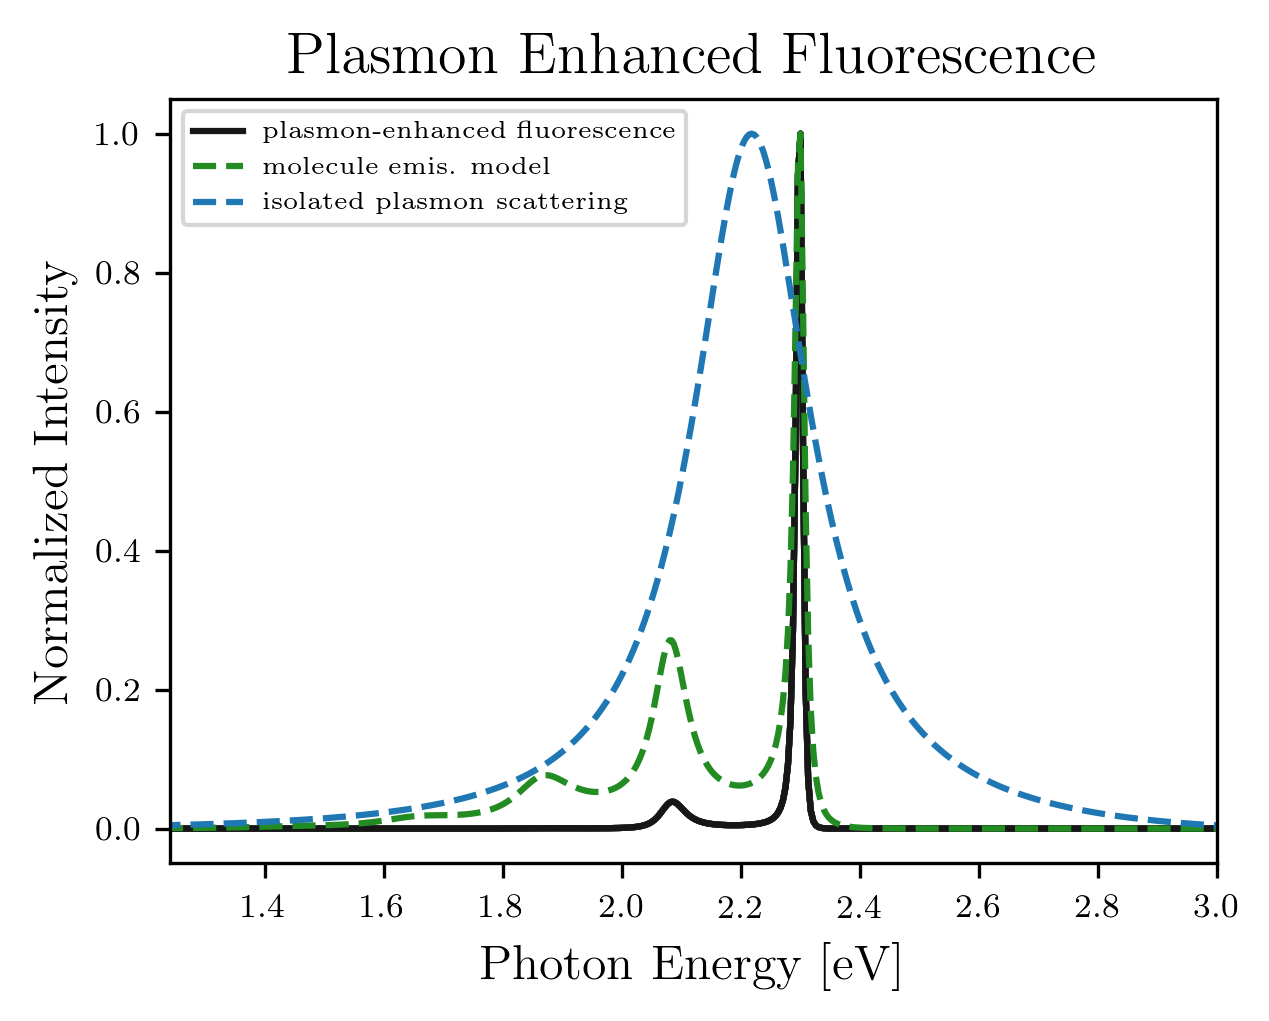

In [155]:

## Define parameters for modeled spetra
plas_parameters = [
    9.82335326,  # eps_inf
    9.06705560,  # w_p
    0.0334860149,  # gamma
    1.33**2.,  # eps_b
    41*1e-7  # a
    ]

further_shift = 0/hbar

## Set up list to hold spectra at each seperation
scat = []
comps = []

## Iterate through molecule plasmon displacement
for i, d in enumerate(np.arange(10, 101, 10)):
    dcol = np.array([[d, 0, 0]])

    ## Define plasmon polarizability as a function of frequency
    def alpha_pla_of_w(w): 
        alpha = cp.sparse_ret_sphere_polarizability_Drude(
            w=hw/hbar, 
            eps_inf=plas_parameters[0], 
            w_p=plas_parameters[1]/hbar, 
            gamma=plas_parameters[2]/hbar, 
            eps_b=plas_parameters[3], 
            a=plas_parameters[4]
            )
        return alpha

    ## Define uncoupled plasmon spectrum
    def plas_scat(w):
        spec = (
            cp.sigma_prefactor(w, eps_b = plas_parameters[3])
            *
            np.abs(alpha_pla_of_w(w)[...,0,0])**2.
            )
        return spec

    ## Define molecule dipole moment 
    c_w = dom.sigma_e(
    #         (omegas-(1/2*test_script_d**2.*test_hbar_omega_0/hbar)), 
        shifted_w-further_shift,
        script_d=test_script_d, 
        omega_q=test_hbar_omega_0/hbar,
        gamma=test_hbar_gamma/hbar,
        t_bound=test_t_bound, 
        t_points=test_t_points,
        T = test_T
        )

    ## Define coupled dipole amplitudes as a function of frequency 
    def dips_per_om(w):
        return cp.plas_dip_driven_by_mol(
            0, 0, dcol,
    #         -c_w_conj,
            mol_dipole_mag=1J*c_w/hbar*drive_amp,
            E_d_angle=0, 
            drive_hbar_w=w,
            alpha1_diag=alpha_pla_of_w(hw),
            n_b=1,
    #         drive_amp=drive_amp
            )

    _scat, _comps = cp.sigma_scat_coupled(
        dips_per_om,
        dcol, 
        hw/hbar,
        n_b=1,
        E_0=drive_amp,
        )
    
    scat.append(_scat)
    comps.append(_comps)

for i in range(10):
    ## Make some plots
    if i is 9: 
        plt.plot(
            hw, scat[i]/scat[i].max(), 
            c=plt.cm.gray_r(.1 + (i/10)*(.9)),
            label='plasmon-enhanced fluorescence')
    else:    
        plt.plot(
            hw, scat[i]/scat[i].max(), 
            c=plt.cm.gray_r(.1 + (i/10)*(.9)),
            )
#             label='plasmon-enhanced fluorescence')

## plot molecule emission 
emission = np.real(c_w)
plt.plot(
    hbar_omegas, 
    emission/emission.max(),
    c='forestgreen',
    ls='--', 
    label='molecule emis. model'
    )
plt.plot(
    hw, 
    plas_scat(hw/hbar)/plas_scat(hw/hbar).max(),
    c='C0',
    ls='--',
    label='isolated plasmon scattering')
plt.legend(
    fontsize=6, 
#     title=f'seperation = {i:d} nm', 
    title_fontsize=8
    )
plt.xlim([hw.min(), 3])
plt.ylabel('Normalized Intensity')
plt.xlabel('Photon Energy [eV]')
plt.title('Plasmon Enhanced Fluorescence')
plt.show()

[[1.e-05 0.e+00 0.e+00]]


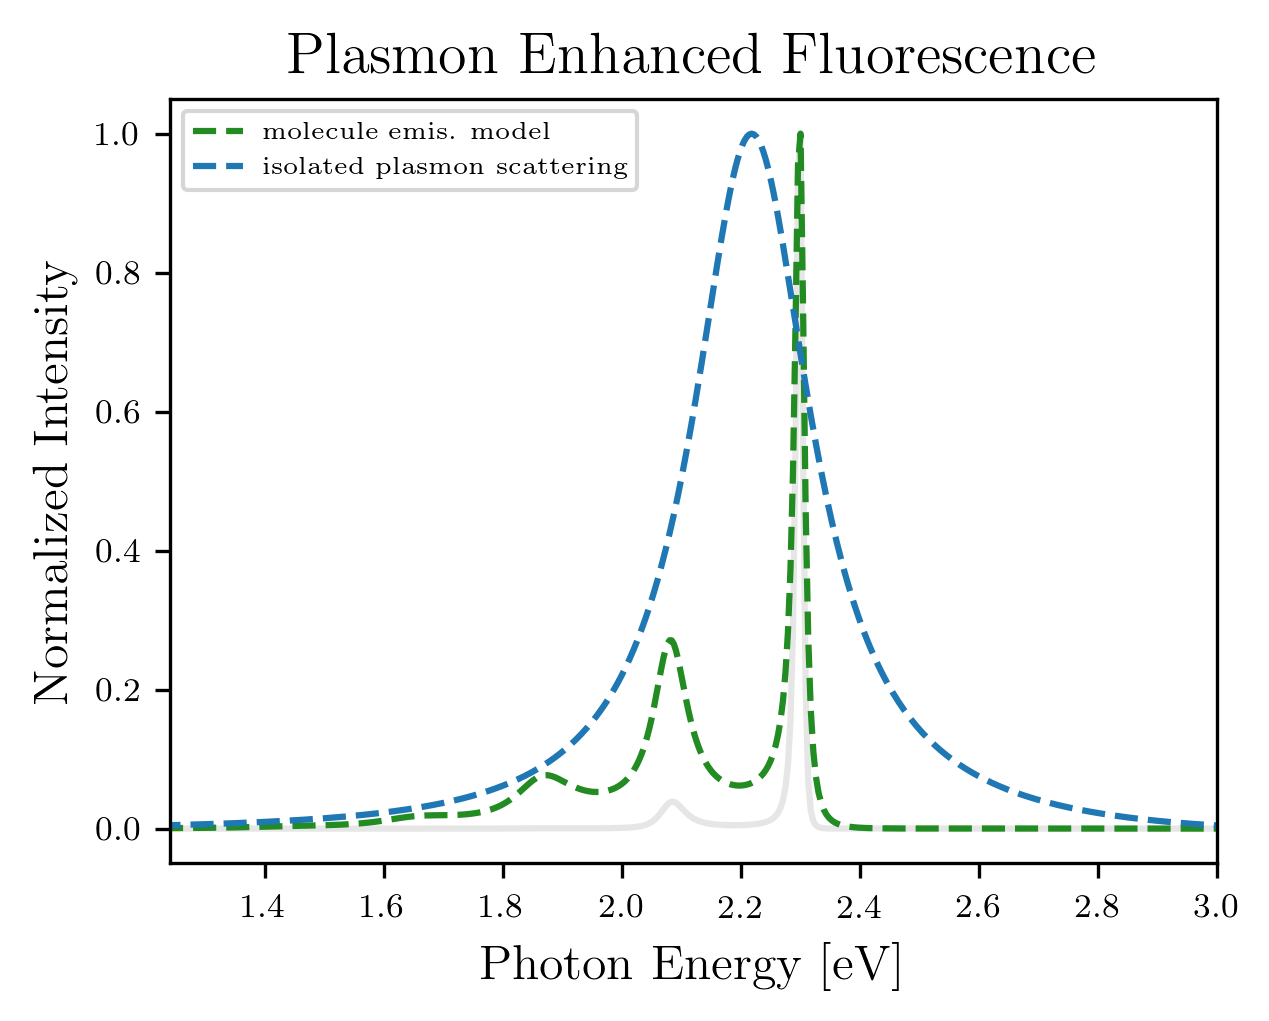

In [175]:

## Define parameters for modeled spetra
plas_parameters = [
    9.82335326,  # eps_inf
    9.06705560,  # w_p
    0.0334860149,  # gamma
    1.33**2.,  # eps_b
    41  # a
    ]

further_shift = 0/hbar

## Set up list to hold spectra at each seperation
scat = []
comps = []

sep_iter = [100]
## Iterate through molecule plasmon displacement
for i, d in enumerate(sep_iter):
    dcol = np.array([[d, 0, 0]])*1e-7
    print(dcol)

    ## Define plasmon polarizability as a function of frequency
    def alpha_pla_of_w(w): 
        alpha = cp.sparse_ret_sphere_polarizability_Drude(
            w=hw/hbar, 
            eps_inf=plas_parameters[0], 
            w_p=plas_parameters[1]/hbar, 
            gamma=plas_parameters[2]/hbar, 
            eps_b=plas_parameters[3], 
            a=plas_parameters[4]*1e-7
            )
        return alpha

    ## Define uncoupled plasmon spectrum
    def plas_scat(w):
        spec = (
            cp.sigma_prefactor(w, eps_b = plas_parameters[3])
            *
            np.abs(alpha_pla_of_w(w)[...,0,0])**2.
            )
        return spec

    ## Define molecule dipole moment 
    c_w = dom.sigma_e(
    #         (omegas-(1/2*test_script_d**2.*test_hbar_omega_0/hbar)), 
        shifted_w-further_shift,
        script_d=test_script_d, 
        omega_q=test_hbar_omega_0/hbar,
        gamma=test_hbar_gamma/hbar,
        t_bound=test_t_bound, 
        t_points=test_t_points,
        T = test_T
        )

    ## Define coupled dipole amplitudes as a function of frequency 
    def dips_per_om(w):
        return cp.plas_dip_driven_by_mol(
            0, 
            0, 
            dcol,
    #         -c_w_conj,
            mol_dipole_mag=1J*c_w/hbar*drive_amp,
            E_d_angle=0, 
            drive_hbar_w=w,
            alpha1_diag=alpha_pla_of_w(hw),
            n_b=1,
    #         drive_amp=drive_amp
            )

    _scat, _comps = cp.sigma_scat_coupled(
        dips_per_om,
        dcol, 
        hw/hbar,
        n_b=1,
        E_0=drive_amp,
        )
    
    scat.append(_scat)
    comps.append(_comps)

for i in range(len(sep_iter)):
    ## Make some plots
    if i is 9: 
        plt.plot(
            hw, scat[i]/scat[i].max(), 
            c=plt.cm.gray_r(.1 + (i/len(sep_iter))*(.9)),
            label='plasmon-enhanced fluorescence')
    else:    
        plt.plot(
            hw, scat[i]/scat[i].max(), 
            c=plt.cm.gray_r(.1 + (i/len(sep_iter))*(.9)),
            )
#             label='plasmon-enhanced fluorescence')

## plot molecule emission 
emission = np.real(c_w)
plt.plot(
    hbar_omegas, 
    emission/emission.max(),
    c='forestgreen',
    ls='--', 
    label='molecule emis. model'
    )
plt.plot(
    hw, 
    plas_scat(hw/hbar)/plas_scat(hw/hbar).max(),
    c='C0',
    ls='--',
    label='isolated plasmon scattering')
plt.legend(
    fontsize=6, 
#     title=f'seperation = {i:d} nm', 
    title_fontsize=8
    )
plt.xlim([hw.min(), 3])
plt.ylabel('Normalized Intensity')
plt.xlabel('Photon Energy [eV]')
plt.title('Plasmon Enhanced Fluorescence')
plt.show()

(1.2412412412412412, 3)

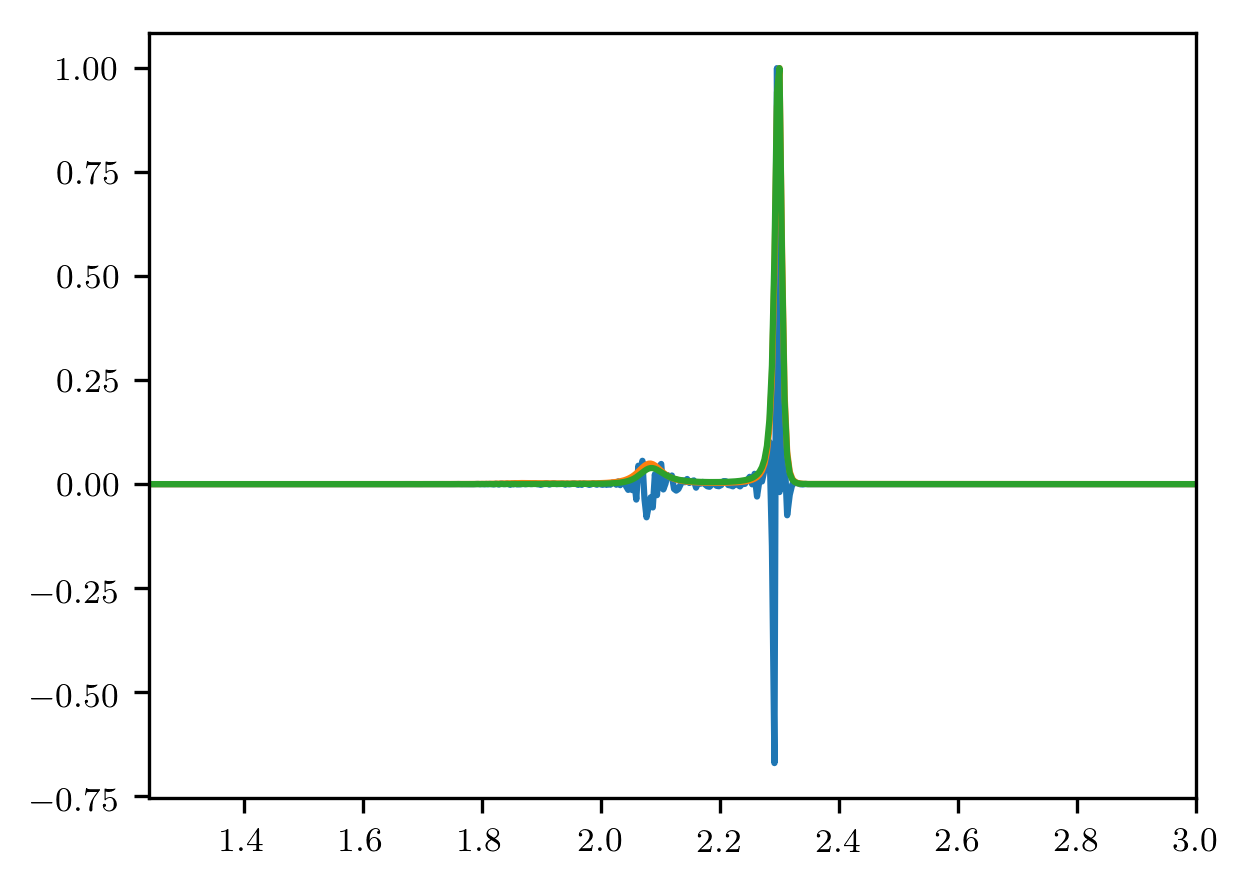

In [178]:
for i, comp in enumerate(comps[0]):

    plt.plot(
        hw, 
        comp/comp.max(),
#         c='C0',
#         ls='--',
        label='isolated plasmon scattering')
    
plt.xlim([hw.min(), 3])


    
    

### Try different molecule parameters


In [ ]:
test_hbar_omega_eg_0 = 2.3
test_script_d = 1.2
# test_hbar_omega_0 = hbar * invcmtohz(300)
# test_hbar_gamma = hbar * invcmtohz(400)
test_hbar_omega_0 = .17
test_hbar_gamma = .1
test_t_bound = 1000
test_t_points = 10000
test_T = 350